# Project: Web Traffic Forecasting
Ruoxin Jiang and Bingyan Hu
## Overview
___
### Task
The goal of our project is to forecast web traffic time series for online pages. Forecasting time series is challenging since we need to combine its seasonality, trend and other factors intelligently in modeling; the historical data itself is insufficient to capture uncertainty in future events. 

We present a hierchical time series forecasting model using Edward and demostrate three rounds of Box's loop below.

+ Hypothesis

### Data Source
We obtain real time series data from [a recent Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting). Each time series represents daily page views of a particular Wikipedia article from **07/01/2015** to **09/10/2017**. 

The model is trained on data before **07/10/2017** and we forecast number of page visits in last 60 days from **07/10/2017** to **09/10/2017**.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import edward as ed
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import itertools

from models import *
from utils import *
from pipeline import *
from cross_validation import cross_validation

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (24, 12)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['xtick.color'] = 'k'
matplotlib.rcParams['ytick.color'] = 'k'
ed.set_seed(42)

## Round 1: 
___
### 1.Data
We randomly pick a wikipedia article data with `ds` and `views` in long format.

+ selection

In [2]:
# Load data into DataFrame
FPATH = "./data/nfl_teams.csv"
#pages = ["Atlanta_Falcons_en.wikipedia.org_mobile-web_all-agents", 
#         "Dallas_Cowboys_en.wikipedia.org_mobile-web_all-agents"]

timeseries = get_timeseries(FPATH)
pages = timeseries.keys()
ts_dfs = []
for p in pages:
    print("Preparing timeseries %s" % p)
    df = setup_dataframe(timeseries[p])
    ts_dfs.append(df)

Loading timeseries:
Preparing timeseries Dallas_Cowboys_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Pittsburgh_Steelers_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Arizona_Cardinals_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Los_Angeles_Rams_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Denver_Broncos_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries National_Football_League_en.wikipedia.org_desktop_all-agents
Preparing timeseries Carolina_Panthers_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Atlanta_Falcons_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Green_Bay_Packers_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries New_England_Patriots_en.wikipedia.org_mobile-web_all-agents


In [3]:
%%capture
# Split history (train) and future (test)
sdate = pd.datetime(2017, 7, 10)
ts_data = []
for df in ts_dfs: 
    history, future, y_scale = split_train_test(df, sdate)
    ts_data.append({
        "history": history, "future": future, "y_scale": y_scale
    })
    
print("Extracting features")
# same feature matrix for all test series  
train_data = extract_features(ts_data[0]["history"])
test_data = extract_features(ts_data[0]["future"], changepoints_t=train_data["t_change"])
assert(all(train_data["X"].columns ==  test_data["X"].columns))
assert(all(train_data["t_change"] == test_data["t_change"]))

ds views         y         t  y_scaled
0 2015-07-01  1046  6.952729  0.000000  0.667247
1 2015-07-02   952  6.858565  0.001351  0.658211
2 2015-07-03   869  6.767343  0.002703  0.649456
3 2015-07-04  1094  6.997596  0.004054  0.671553
4 2015-07-05   844  6.738152  0.005405  0.646655

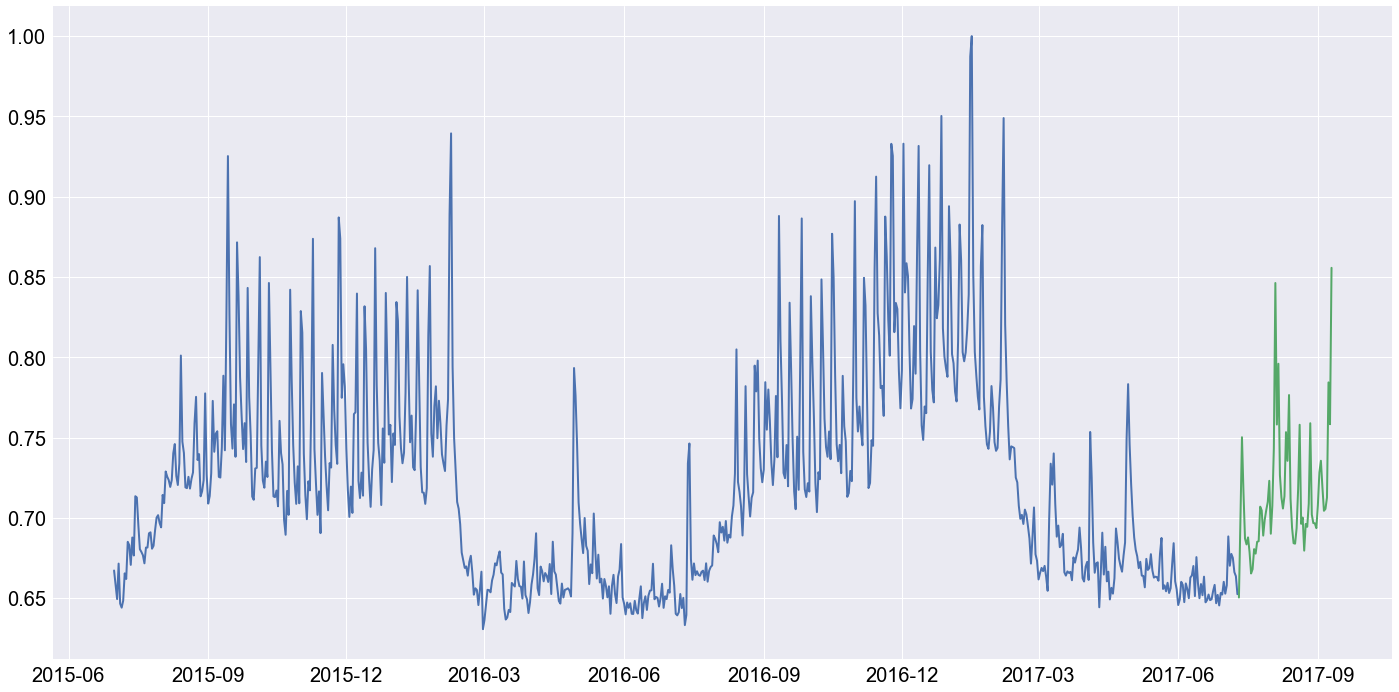

In [4]:
ts_example = ts_data[0]
plt.plot(ts_example["history"]["ds"], ts_example["history"]["y_scaled"])
plt.plot(ts_example["future"]["ds"], ts_example["future"]["y_scaled"])
ts_example["history"].head()

## Model: FB prophet regression model
We build a regression model similar to [Facebook Prophet](https://peerj.com/preprints/3190/); it combines trend, seasonality and holiday components with non-linear smoothers applied to regressors $t \in \mathbb{Z}^{T}$. 

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}  $$

- **Trend** <br/> $$g(t) = (k + \mathbf{a}(t)^{T} \boldsymbol{\delta})t + (m + \mathbf{a}(t)^{T} \boldsymbol{\gamma})$$
    - $k$ is the growth rate (slope)
    - $m$ is the offset (intercept)
    - $S$ changepoints are explicitly defined to allow trend changes at times $s_{j \in {1,2,...,S}}$
        - $\mathbf{a}(t) \in \{0,1\}^{S}$ are changepoint indicators
        - $\delta_{j} \sim Laplace(0,\tau)$ is the change of rate at time $s_{j}$
        - $\gamma_{j}$ is set to $-s_{j}\delta_{j}$ to make the function continuous</br>


- **Seasonality** <br/>
We construct Fourier series to approximate periodic seaonality.
$$s(t) = \sum_{n=1}^{N}(a_{n}cos(\frac{2\pi nt}{P}) + b_{n}sin(\frac{2\pi nt}{P} )) = X(t)  \boldsymbol{\beta}$$
    - $\boldsymbol{\beta} = [a_{1}, b_{1} , ... , a_{N}, b_{N}]^{T}$ and $\boldsymbol{\beta} \sim Normal(0,\sigma^{2})$
    - yearly -> (P = 365.25, N = 10)
    - weekly -> (P = 7, N = 3)
    

- **Holiday/Events** <br/>
Assuming holidays are independnet, we assign each holiday with a parameter $\kappa_{i}$
$$h(t) = Z(t) \boldsymbol{\kappa}$$
    - $Z(t) = [\boldsymbol{1}(t\in D_{1}) , ... , \boldsymbol{1}(t\in D_{L})]$
    - $\boldsymbol{\kappa} \sim Normal(0, \nu^2)$

Before modeling, we transform the raw data and extract features into proper format. The input data includes

- X
    - **t: ** time index
    - **X: ** seasonality vector after fourier transformation
    - **A: ** changepoint vector given time and number of change points
    - **sigmas: ** fixed scale on seasonality priors
- y
    - **y_scaled: ** `maxdiff(log(views))`

In [5]:
N_TS = len(ts_data)
S = len(train_data["t_change"])
K = train_data["X"].shape[1]

t = tf.placeholder(tf.float32, shape=None, name="t")              # time index
A = tf.placeholder(tf.float32, shape=(None, S), name="A")         # changepoint indicators
t_change = tf.placeholder(tf.float32, shape=(S), name="t_change") # changepoints_t
X = tf.placeholder(tf.float32, shape=(None, K), name="X")         # season vectors
sigmas = tf.placeholder(tf.float32, shape=(K,), name="sigmas")    # scale on seasonality prior
tau = tf.placeholder(tf.float32, shape=(), name="tau")

k = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))     # initial slope
m = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))     # initial intercept

sigma_obs = Normal(loc=tf.zeros(1), scale=0.5*tf.ones(1))   # noise
delta = Laplace(loc=tf.zeros(S), scale=tau*tf.ones(S))    # changepoint rate adjustment
gamma = tf.multiply(-t_change, delta)
beta = Normal(loc=tf.zeros(K), scale=sigmas*tf.ones(K))      # seasonal
trend_loc = (k + ed.dot(A, delta)) * t + \
            (m + ed.dot(A, gamma))
seas_loc = ed.dot(X, beta)
y = Normal(loc = trend_loc + seas_loc, scale = sigma_obs)

### 1.Inference: HMC
Given train data, the goal is to infer $k,m,\boldsymbol{\delta},\tau,\boldsymbol{\beta}$ and $\sigma$, where k and m are trend model parameters, $\boldsymbol{\delta}$ are latent variables for rate adjustment, $\boldsymbol{\beta}$ are smoothers for seasonality, $\tau$ and $\sigma$ are variance component parameters.

In this analysis, we use Monte Carlo with `ed.HMC` to infer all the latent variables. All training data are passed in for inference and we tune step_size $= 0.0005$, n_steps $= 2$.

In [6]:
ITR = 5000
kinit, minit = init_km(ts_example["history"])
print("[+] Initial slope / intercept: %f, %f" % (kinit, minit))
qk = Empirical(params=tf.Variable(kinit * tf.ones([ITR, 1])))
qm = Empirical(params=tf.Variable(minit * tf.ones([ITR, 1])))
qsigma_obs = Empirical(params=tf.Variable(tf.ones([ITR, 1])))
qbeta = Empirical(params=tf.Variable(tf.zeros([ITR, K])))
qdelta = Empirical(params=tf.Variable(tf.zeros([ITR, S])))

[+] Initial slope / intercept: -0.014748, 0.667247


In [7]:
posts_dict = {
    k: qk, m: qm, sigma_obs: qsigma_obs,
    beta: qbeta, delta: qdelta}

data_dict = {
    y: ts_data[0]["history"]["y_scaled"].as_matrix(),
    t: train_data["t"],
    X: train_data["X"],
    sigmas: train_data["sigmas"],
    A: train_data["A"],
    t_change: train_data["t_change"],
    tau: 0.05,
}

inference = ed.HMC(posts_dict, data=data_dict)
STEP_SIZE = 5e-4
N_STEPS = 2
inference.run(step_size=STEP_SIZE, n_steps=N_STEPS)

5000/5000 [100%] ██████████████████████████████ Elapsed: 15s | Acceptance Rate: 0.959


### 1.Prediction

In [8]:
## Posterior (Samples + Manual burnin)
## https://github.com/blei-lab/edward/blob/e8e94174c4b8f4ef7fedde90e47c0a61de75ade4/edward/inferences/monte_carlo.py

nburn = int(ITR / 2)
stride = 10
sess = ed.get_session()
post_params = {
    "k": qk.params.eval()[nburn:ITR:stride],
    "m": qm.params.eval()[nburn:ITR:stride],
    "beta": qbeta.params.eval()[nburn:ITR:stride],
    "delta": qdelta.params.eval()[nburn:ITR:stride]
}

In [9]:
from prediction import *

pred_example = make_future_dataframe(ts_example["history"], ts_example["future"].shape[0])
pred_example = predict_fixed(pred_example, post_params, test_data)
pred_example.head()

ds         t     trend  seasonal  seasonal_lower  seasonal_upper  \
0 2017-07-11  1.001351  0.714601 -0.057438       -0.065166       -0.049425   
1 2017-07-12  1.002703  0.714431 -0.069057       -0.076959       -0.061135   
2 2017-07-13  1.004054  0.714261 -0.068656       -0.077216       -0.060197   
3 2017-07-14  1.005405  0.714091 -0.056062       -0.064264       -0.048183   
4 2017-07-15  1.006757  0.713922 -0.061972       -0.070333       -0.053856   

     weekly  weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0 -0.004173     -0.008524      0.000066 -0.053265     -0.059890     -0.046373   
1 -0.016028     -0.020199     -0.012169 -0.053029     -0.059599     -0.046120   
2 -0.015885     -0.020100     -0.011696 -0.052771     -0.059513     -0.045831   
3 -0.003592     -0.007581      0.000147 -0.052470     -0.059420     -0.045247   
4 -0.009867     -0.013995     -0.006014 -0.052106     -0.059027     -0.044612   

          y  
0  0.657162  
1  0.645374  
2  0.645605  
3  0.658030  
4  0.651949

In [10]:
y_true = ts_example["future"]["y_scaled"].as_matrix()
metrics_example  = evaluate(y_true, pred_example["y"], prefix="example")
m_pd = pd.DataFrame.from_dict([metrics_example])
m_pd.loc['mean'] = m_pd.mean()
print(m_pd)

      example-MAPE  example-MSE  example-SMAPE
0         3.920031     0.001555       4.029878
mean      3.920031     0.001555       4.029878


In [11]:
# Training 

pred_train_example = pd.DataFrame({"ds": ts_example["history"]["ds"].copy(),
                                  "t": ts_example["history"]["t"].copy()})
pred_train_example.reset_index(inplace=True, drop=True)
pred_train_example = predict_fixed(pred_train_example, post_params, train_data)

In [12]:
## train + test (prediction + trend + yearly + weekly +residual)

def plot_component(results, results_train, component, ts_idx, cs):
    for j, r in enumerate(results):
        df = r["predictions"][ts_idx]
        plt.plot(ts_data[ts_idx]["future"]["t"], df[component], color=cs[j])
        if results_train is not None:
            df_train = results_train[j]["predictions"][ts_idx]
            plt.plot(ts_data[ts_idx]["history"]["t"], df_train[component].as_matrix(), color=cs[j])
        #plt.fill_between(ts_data[i]["future"]["t"], df["y_scaled_pred_lower"], df["y_scaled_pred_upper"], color=c, alpha=.05)
    plt.legend(loc=2, prop={'size': 24})
    plt.show()
    
def visualize_results(results, results_train, ts_data, ts_idx=0):
    ts = ts_data[ts_idx]
    cs = ['C1', 'C3', 'C5']
    
    # True data
    plt.plot(ts["history"]["t"], ts["history"]["y_scaled"].as_matrix(), lw=1, color='C2')
    plt.plot(ts["future"]["t"], ts["future"]["y_scaled"].as_matrix(), lw=1, color='C2')
    
    for j, r in enumerate(results):
        df = r["predictions"][ts_idx] 
        plt.plot(ts["future"]["t"], df["y"].as_matrix(), label="Model %d" % j, color=cs[j])
        if results_train is not None:
            df_train = results_train[j]["predictions"][ts_idx]
            plt.plot(ts["history"]["t"], df_train["y"], color=cs[j])
        #lt.fill_between(ts_data[i]["future"]["t"], df["y_scaled_pred_lower"], df["y_scaled_pred_upper"], color=c, alpha=.05)
    plt.legend(loc=2, prop={'size': 24})
    plt.show()
    
    plt.subplot(411)
    plot_component(results, results_train, "trend", ts_idx, cs)
    plt.subplot(412)
    plot_component(results, results_train, "yearly", ts_idx, cs)
    plt.subplot(413)
    plot_component(results, results_train, "weekly", ts_idx, cs)  
    plt.subplot(414)
    
    # Residual
    for j, r in enumerate(results):
        df = r["predictions"][ts_idx] 
        plt.plot(ts["future"]["t"], ts["future"]["y_scaled"].as_matrix() - df["y"].as_matrix() , color=cs[j], label='residual')
        if results_train is not None:
            df_train = results_train[j]["predictions"][ts_idx]
            plt.plot(ts["history"]["t"], ts["history"]["y_scaled"].as_matrix() - df_train["y"].as_matrix(), color=cs[j])
    plt.legend(loc=2, prop={'size': 24})
    plt.show()  


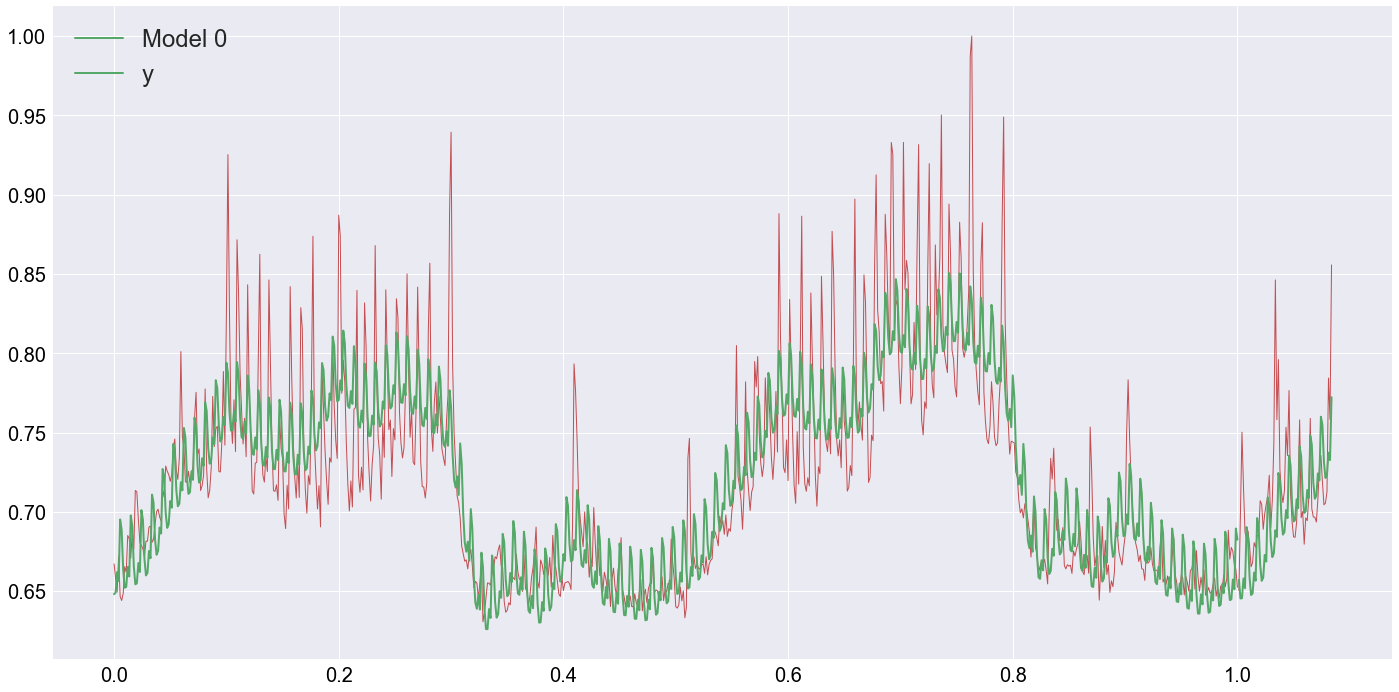

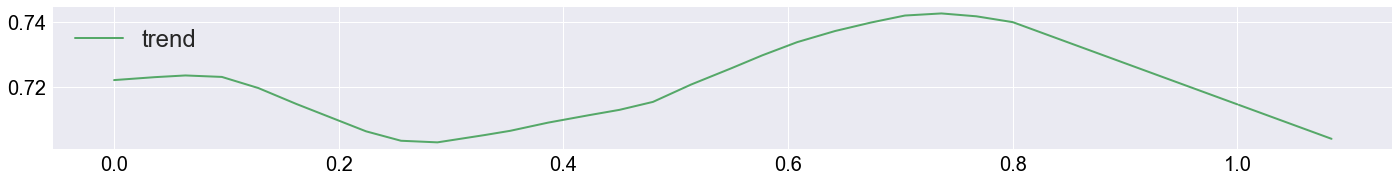

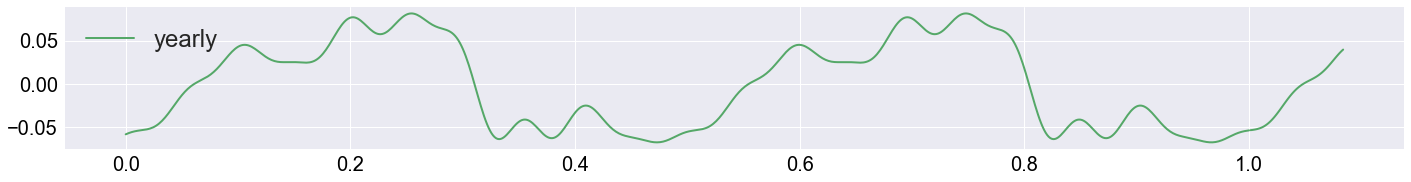

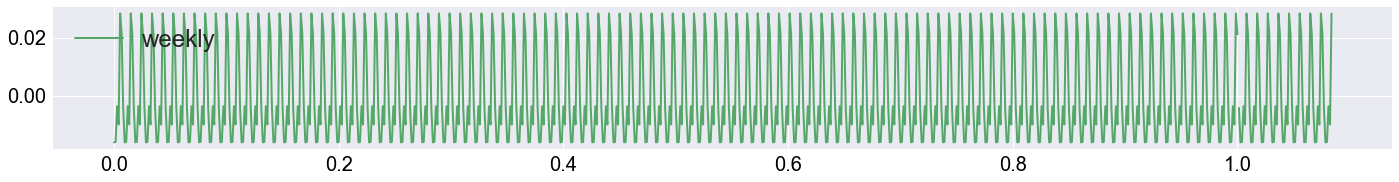

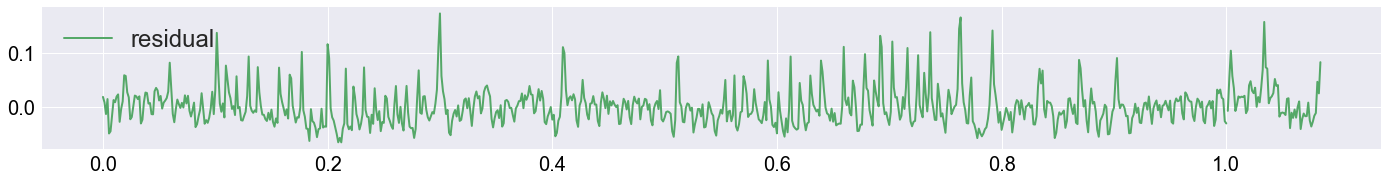

In [13]:
result_example = {"predictions": [pred_example], 
                  "metrics": [metrics_example]}
result_train_example = {"predictions": [pred_train_example]}
visualize_results([result_example], [result_train_example], ts_data, ts_idx=0)

### 1.Criticism
- Visualization of the residuals
- Pointwise Evaluation
    - MAPE
    - SMAPE
    - MSE
- PPC

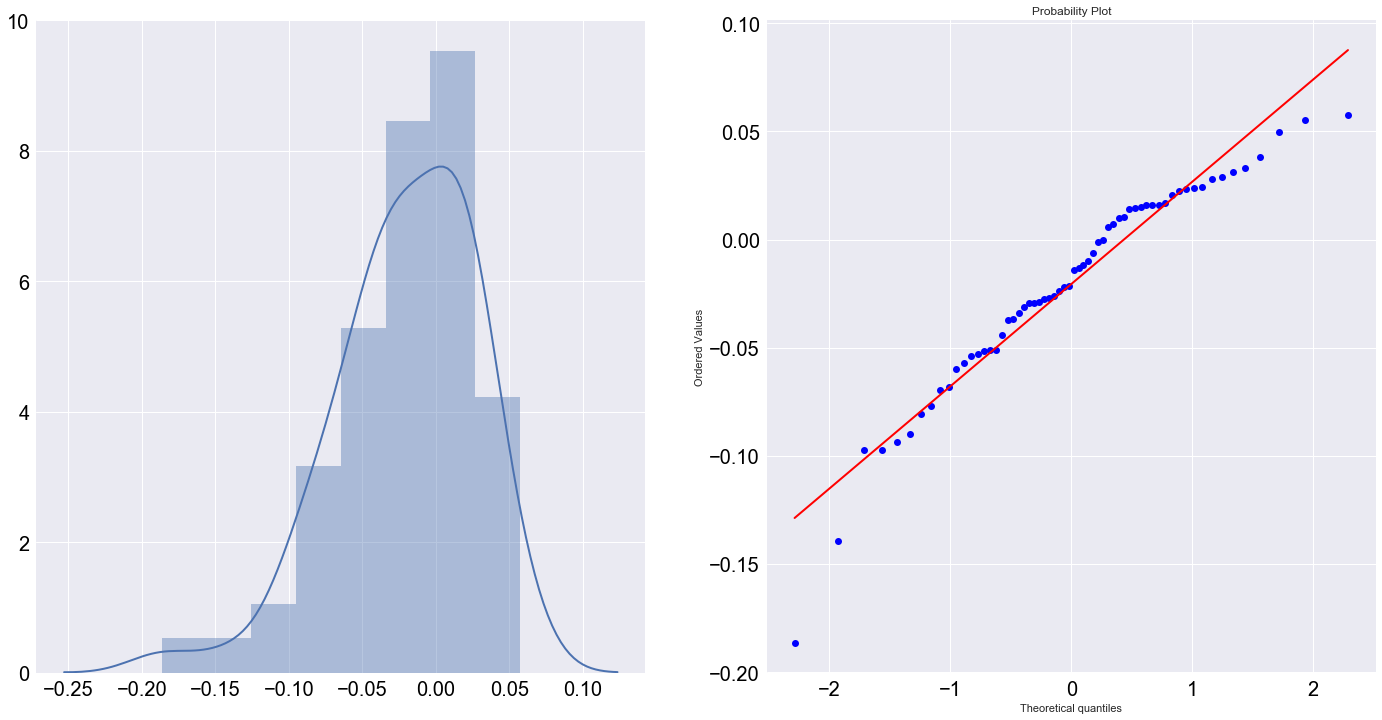

In [14]:
# Percentage Residual Check 
import scipy.stats as stats

plt.subplot(121)
resids = (pred_example["y"].as_matrix() - ts_example["future"]["y_scaled"].as_matrix()) / ts_example["future"]["y_scaled"].as_matrix()
sns.distplot(resids)
plt.subplot(122)
stats.probplot(resids, dist="norm", plot=plt)
plt.show()

In [15]:
# Posterior check
sess = ed.get_session()
kmean, kstddev = np.mean(post_params["k"]), np.std(post_params["k"])
print("Inferred posterior k: mean = %f, stddev = %f" % (kmean, kstddev))
mmean, mstddev = np.mean(post_params["m"]), np.std(post_params["m"])
print("Inferred posterior m: mean = %f, stddev = %f" % (mmean, mstddev))

# plt.plot(qk.params.eval())
# plt.show()

# plt.plot(post_params["k"])
# plt.show()
# nburn = int(ITR/2)
# stride = 10
# print(ITR)
# for beta in post_params["beta"]:
#     plt.plot(beta, 'o')
# plt.show()

Inferred posterior k: mean = 0.025421, stddev = 0.013214
Inferred posterior m: mean = 0.722190, stddev = 0.004973


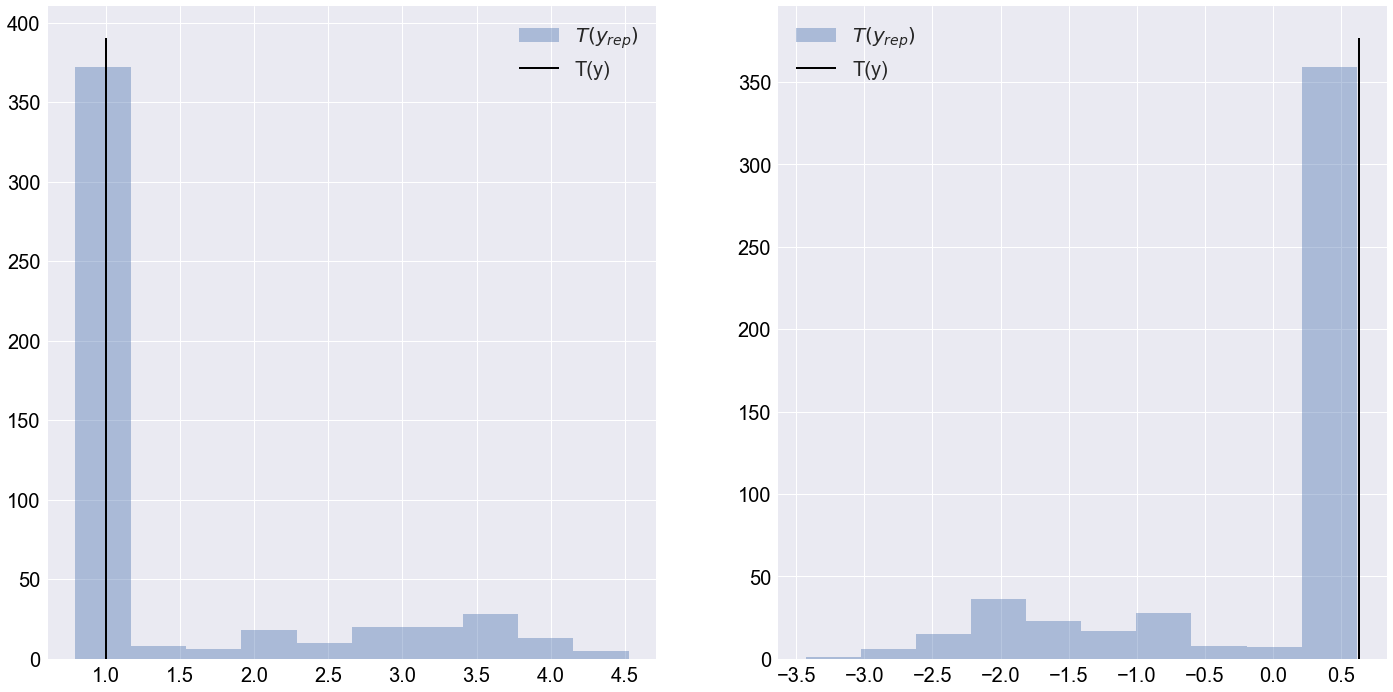

In [16]:
y_post = ed.copy(y, posts_dict)
ty_rep, ty = ed.ppc(lambda xs, zs: tf.reduce_max(tf.cast(xs[y_post], tf.float32)), 
       data={y_post:ts_data[0]["history"]["y_scaled"].as_matrix(), 
            t: train_data['t'],
            A: train_data['A'], 
            X: train_data['X'].as_matrix(), 
            sigmas: train_data['sigmas'], 
            t_change: train_data["t_change"]},n_samples=500)    
plt.subplot(121)
ed.ppc_stat_hist_plot(
    ty[0], ty_rep, stat_name=r'$T \equiv$max', bins=10)
plt.legend(fontsize=20)
plt.subplot(122)
ty_rep, ty = ed.ppc(lambda xs, zs: tf.reduce_min(tf.cast(xs[y_post], tf.float32)), 
       data={y_post:ts_data[0]["history"]["y_scaled"].as_matrix(), 
            t: train_data['t'],
            A: train_data['A'], 
            X: train_data['X'].as_matrix(), 
            sigmas: train_data['sigmas'], 
            t_change: train_data["t_change"]},n_samples=500)    
ed.ppc_stat_hist_plot(
    ty[0], ty_rep, stat_name=r'$T \equiv$min', bins=10)
plt.legend(fontsize=20)
plt.show()

In [17]:
# history_pred_df.index = history_pred_df["ds"]
# decomposition = seasonal_decompose(ts["history"]["y_scaled"].as_matrix() - history_pred_df["y"])
# plt.subplot(411) 
# plt.plot(decomposition.trend)
# plt.subplot(412)
# plt.plot(decomposition.seasonal)
# plt.subplot(413)
# plt.plot(decomposition.resid)
# plt.subplot(414)
# plt.plot(ts["future"]["ds"], y_true - pred_df["y"])
# plt.show()

## Round 2: 
___
### 2.Model
We modify the model by creating global latent variable inferring local seasonality  
- Local latend variable
    - 
- Global latent variable
    - `gbeta`
    
Given train data, the goal is to infer $k,m,\boldsymbol{\delta},\tau,\boldsymbol{\beta}$ and $\sigma$, where k and m are trend model parameters, $\boldsymbol{\delta}$ are latent variables for rate adjustment, $\boldsymbol{\beta}$ are smoothers for seasonality, $\tau$ and $\sigma$ are variance component parameters.

In [18]:
# def visualize_results(ts_data, predictions, metrics):
#     for i, df in enumerate(ts_dfs):
#         plt.plot(ts_data[i]["future"]["ds"], ts_data[i]["future"]["y_scaled"])
#         plt.plot(predictions[i]["ds"], predictions[i]["y_scaled_pred"], '#2ca02c')
#         plt.show()  
#     m_pd = pd.DataFrame.from_dict(metrics)
#     m_pd.loc['mean'] = m_pd.mean()
#     print(m_pd)
#     print()

# def visualize_cross_validation(ts_dfs, predictions, metrics):
#     for i, df in enumerate(ts_dfs):
#         df = df[df["ds"] > pd.datetime(2016,6,1)]
#         plt.plot(df["ds"], df["y"])
#         for pred in predictions:
#             plt.plot(pred[i]["ds"], pred[i]["y_pred"], '#2ca02c')
#         plt.show()
    
#     metrics_df = pd.DataFrame(columns=['start', 'end', 'MAPE_avg', 'SMAPE_avg'])
#     for i, m_cutoff in enumerate(metrics):
#         dmin, dmax = predictions[i][0]["ds"].min(), predictions[i][0]["ds"].max()
#         avg_mape_scaled = np.mean([m["MAPE"] for m in m_cutoff])
#         avg_smape_scaled = np.mean([m["SMAPE"] for m in m_cutoff])
#         metrics_df = metrics_df.append({"start": dmin,
#                                         "end": dmax,
#                                         "MAPE_avg": avg_mape_scaled, 
#                                         "SMAPE_avg": avg_smape_scaled}, ignore_index=True)
    
#     print(metrics_df)

Fitting 10 Timeseries
[+] Building model
[+] Running inference
5000/5000 [100%] ██████████████████████████████ Elapsed: 93s | Acceptance Rate: 0.212
[+] Making prediction


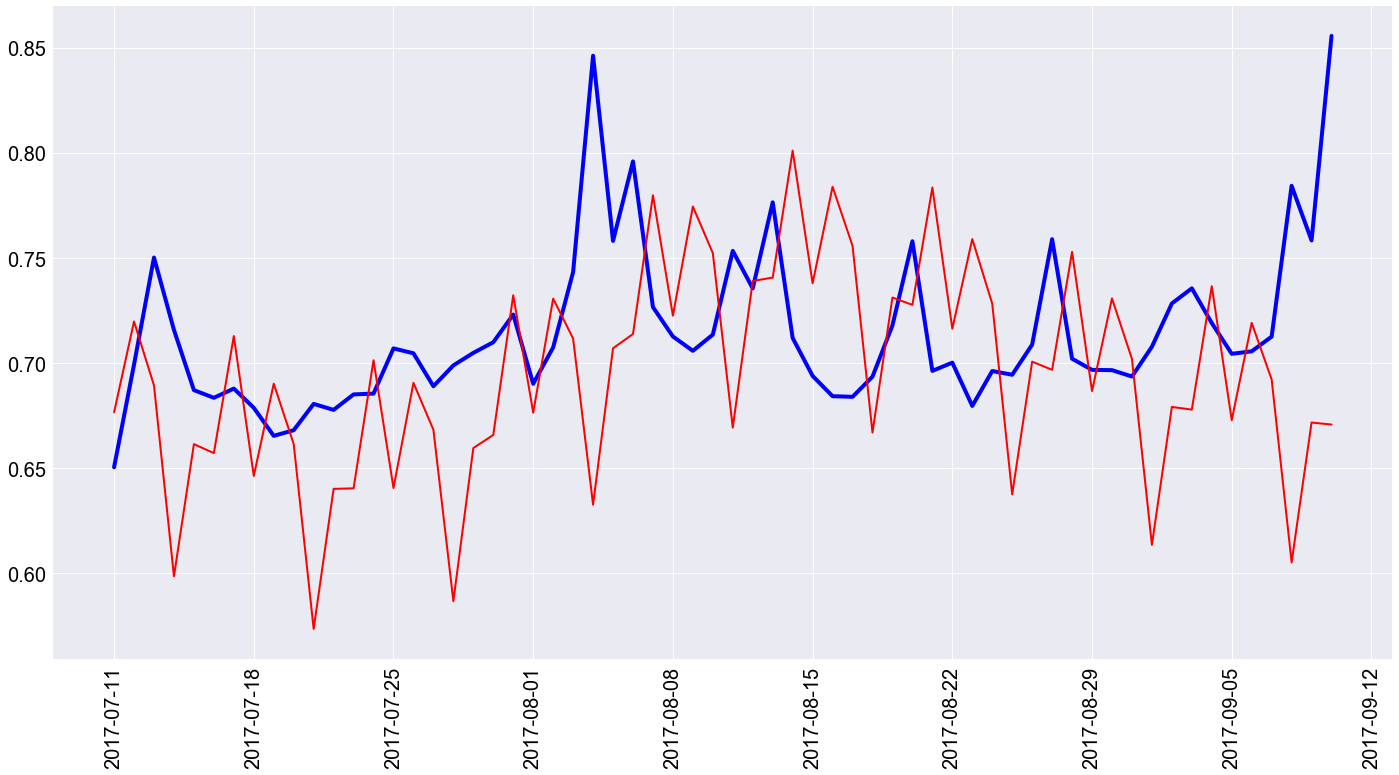

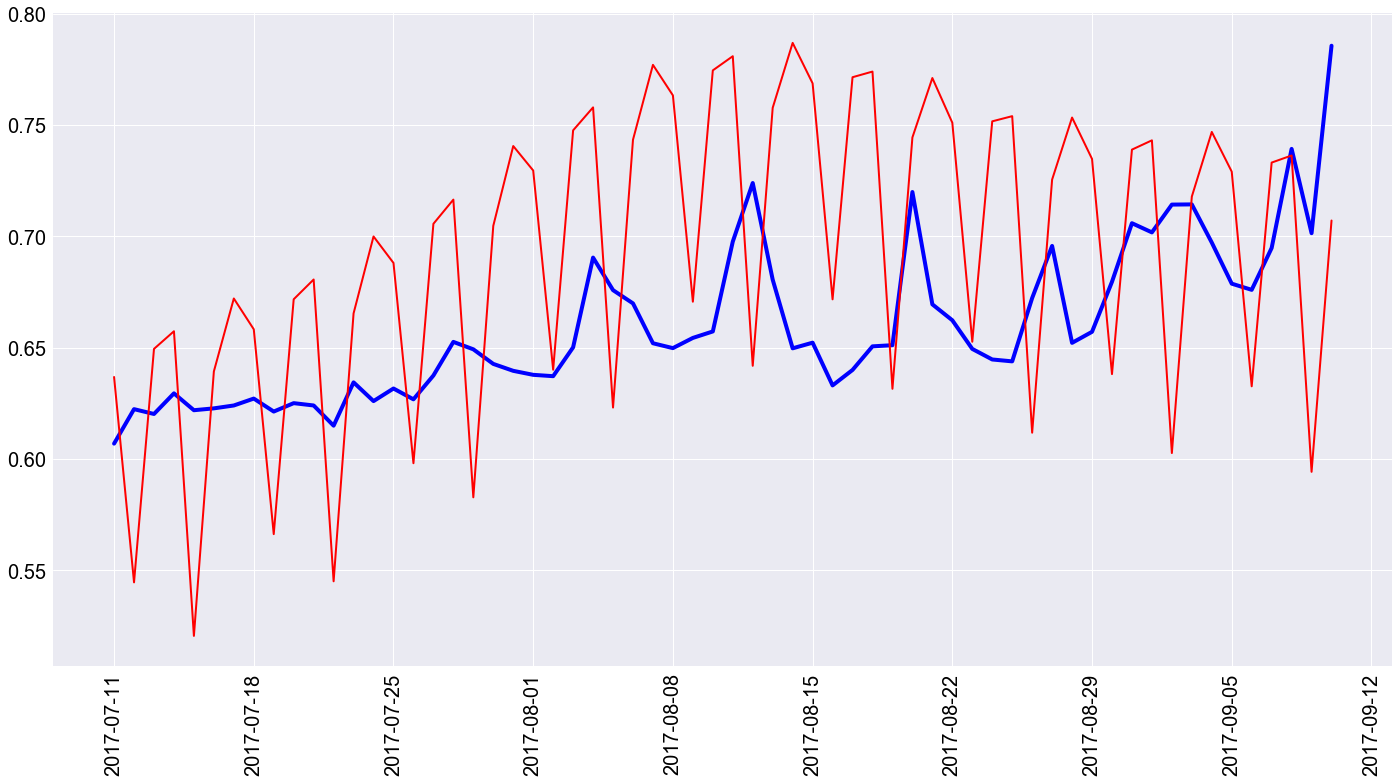

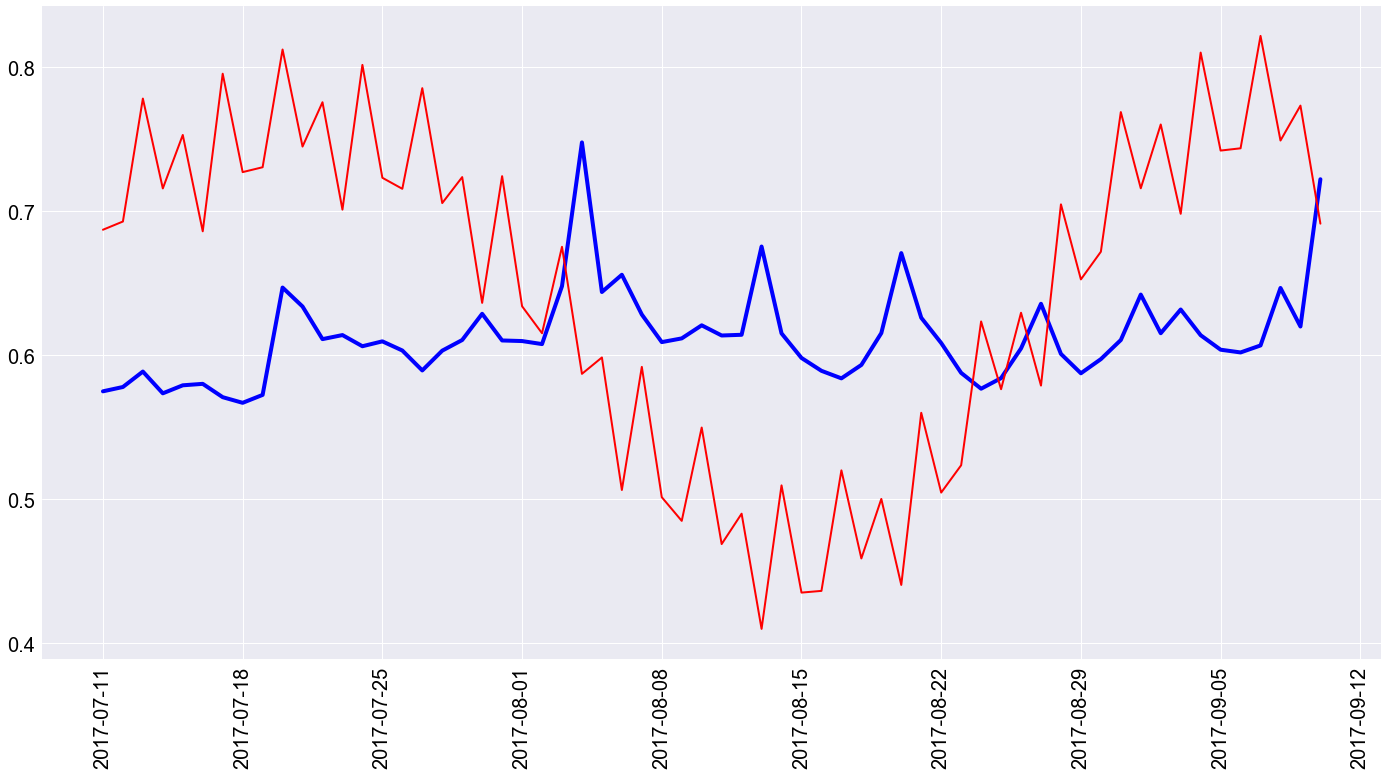

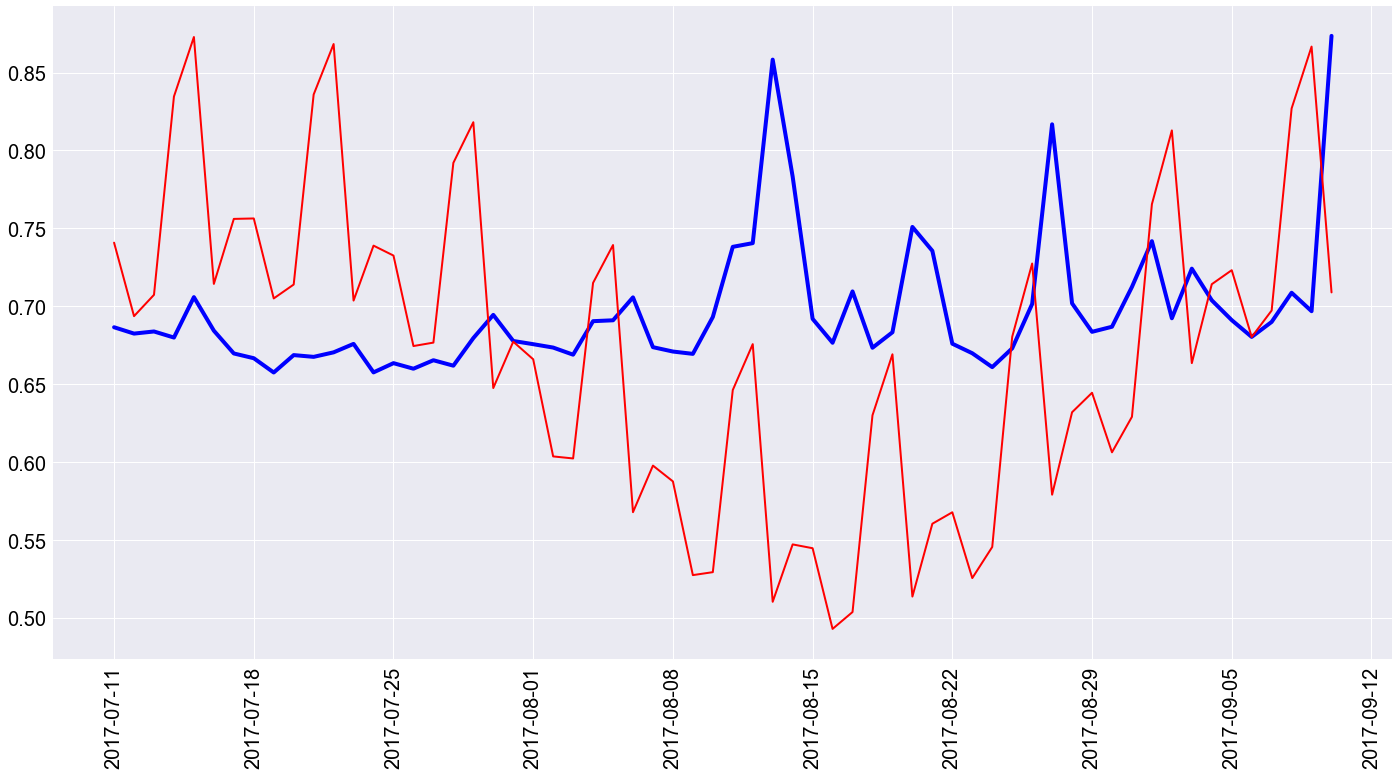

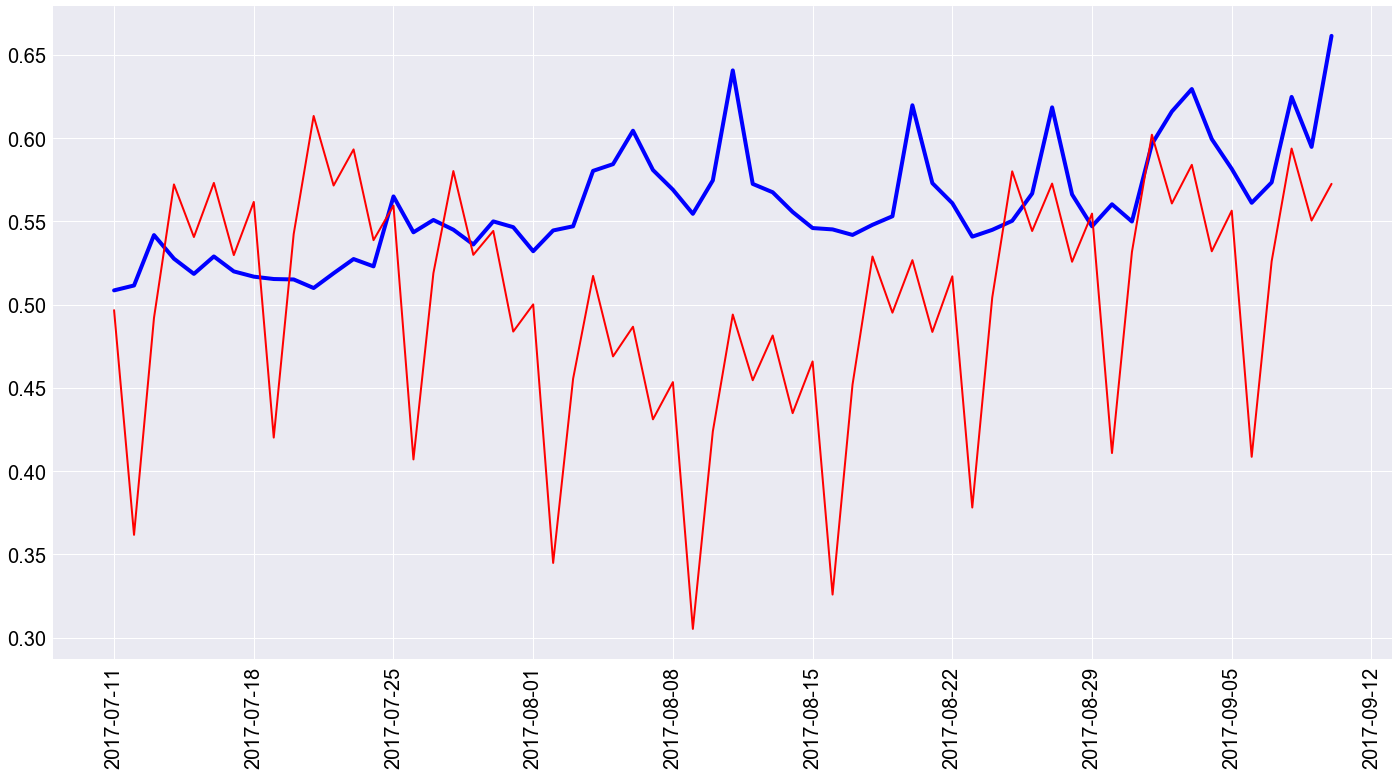

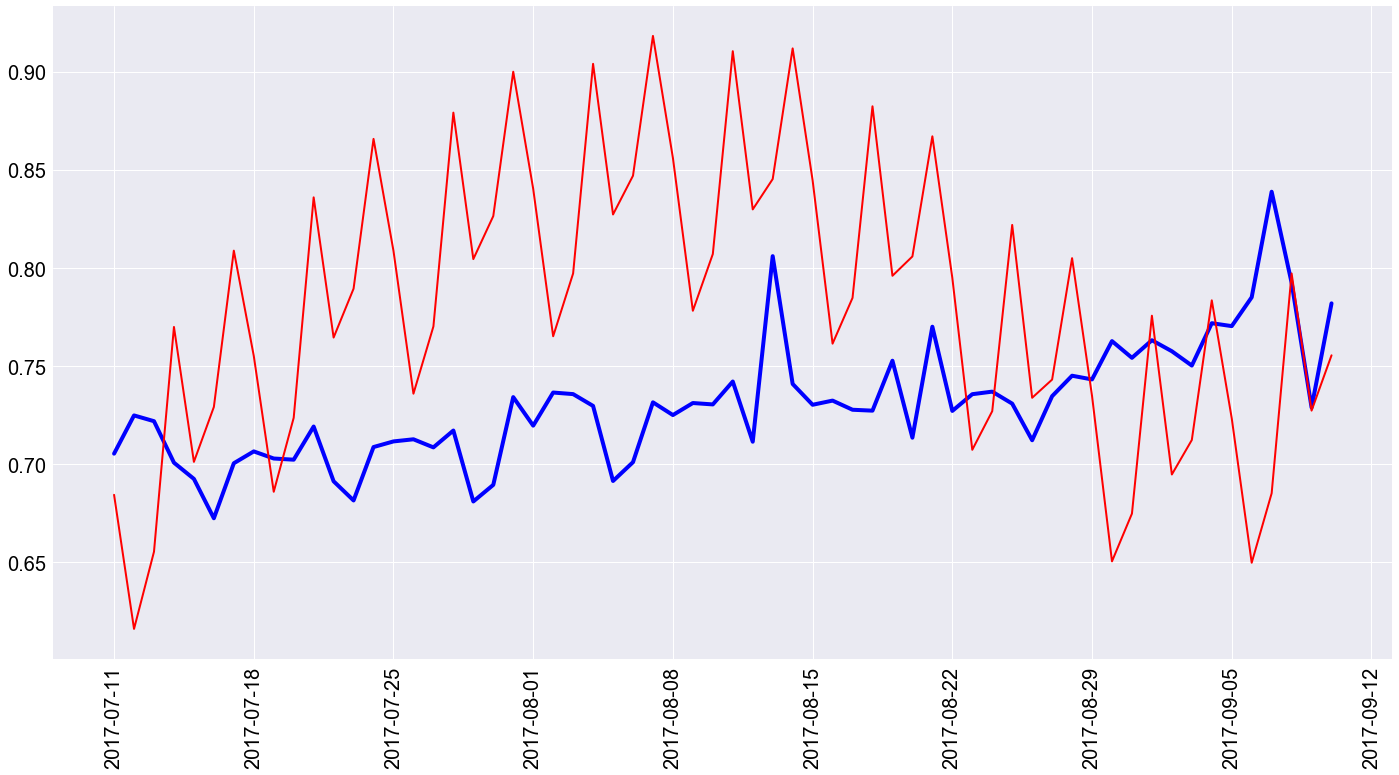

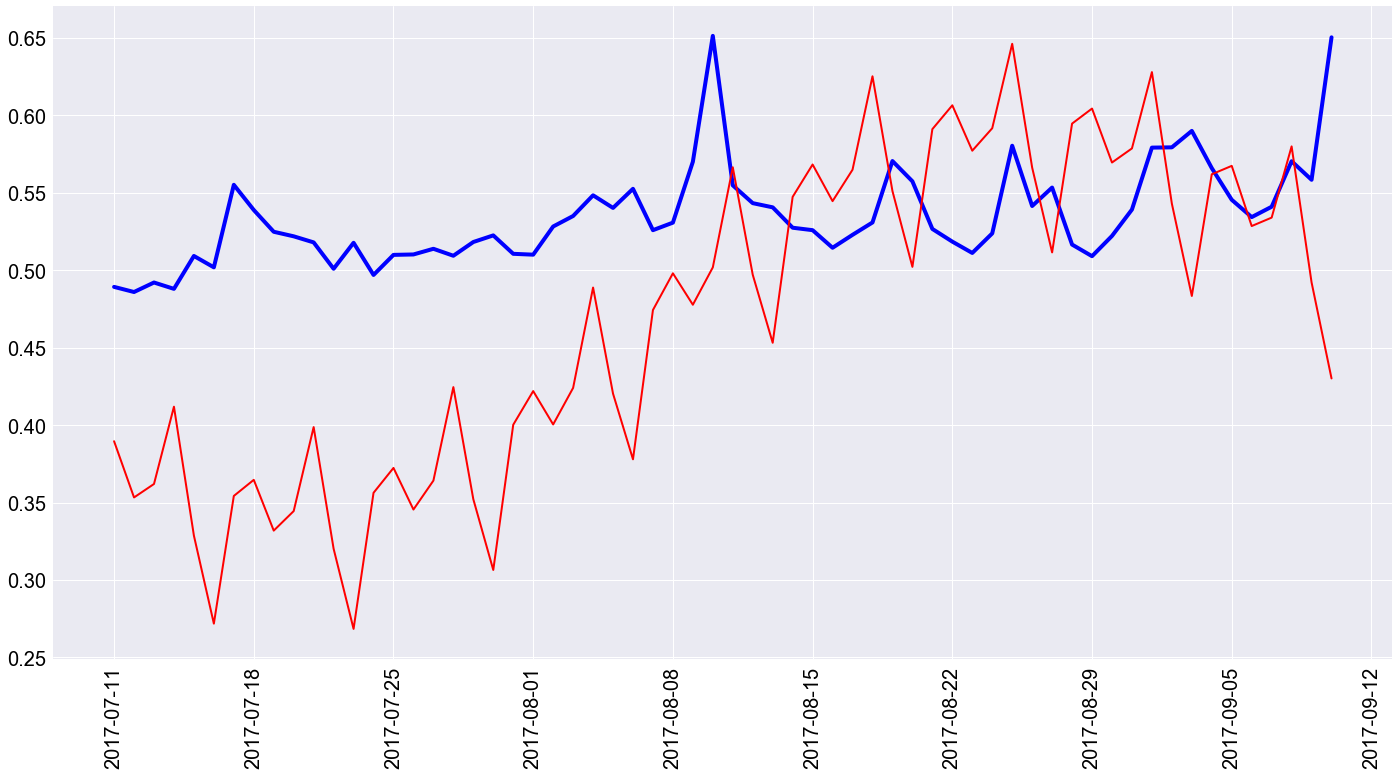

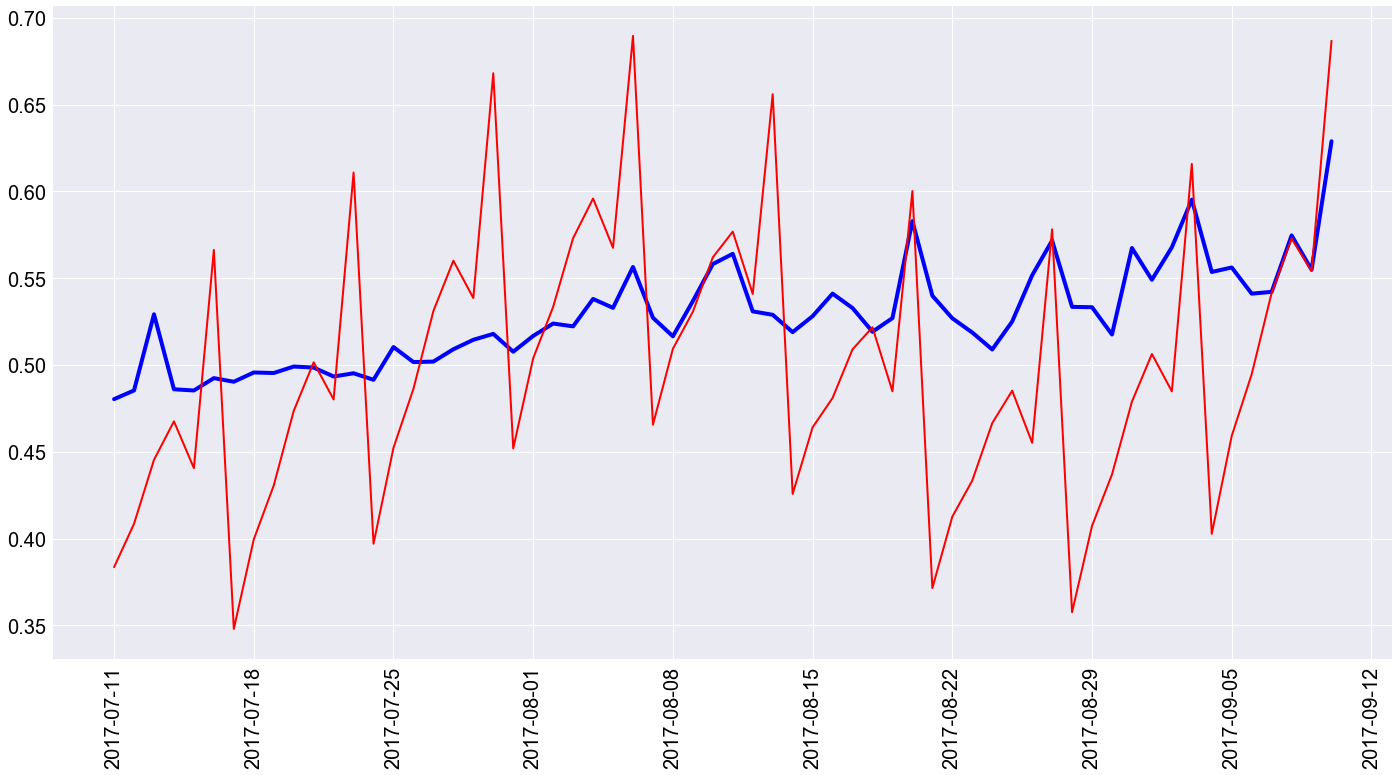

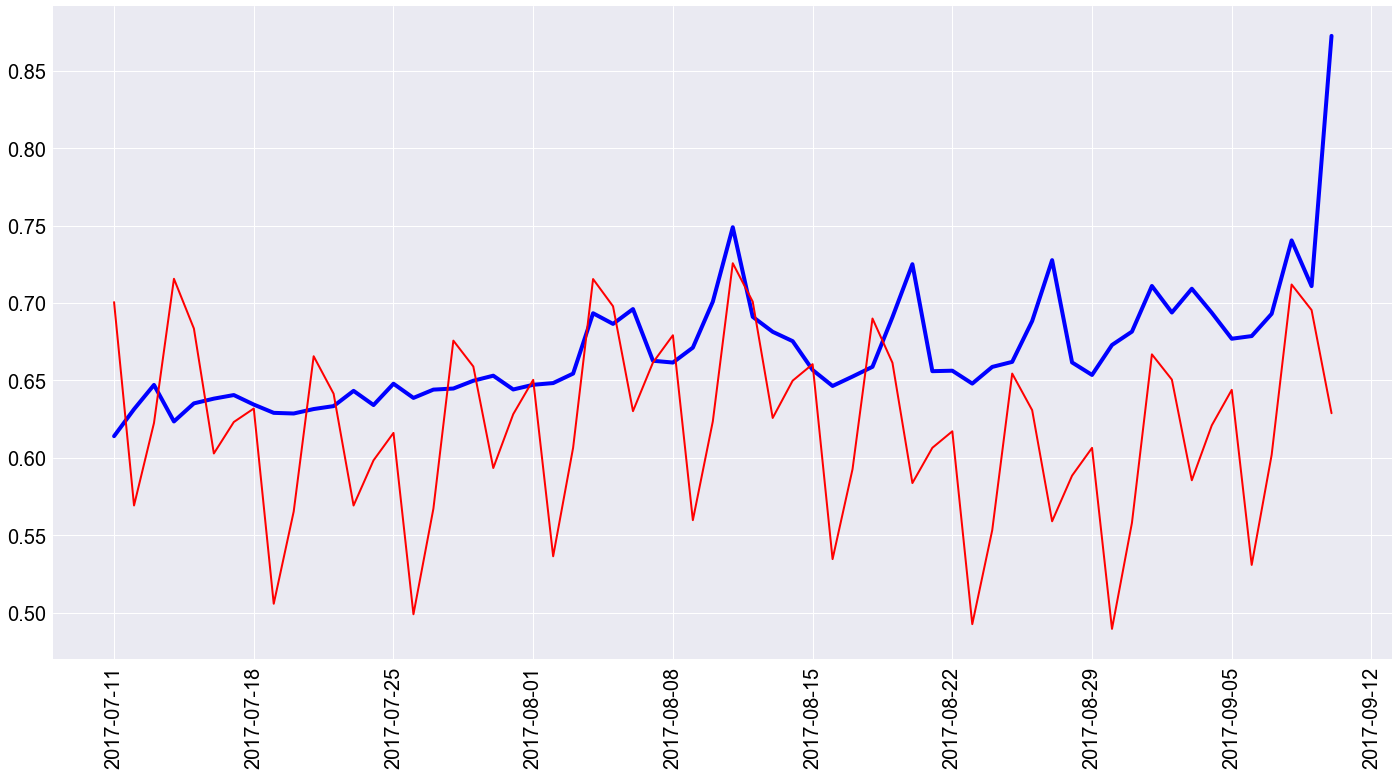

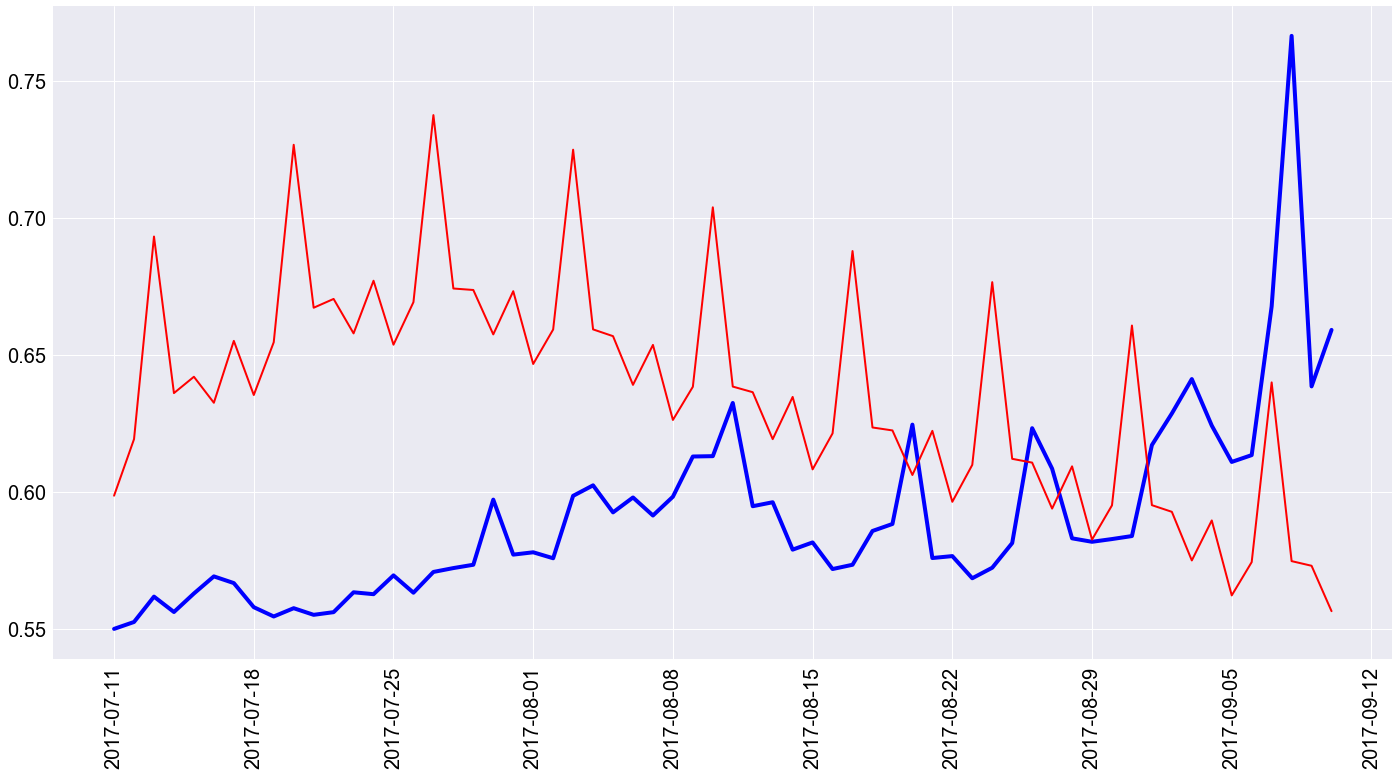

[+] Building model
[+] Initial slope / intercept: -0.014748, 0.667247
[+] Initial slope / intercept: 0.011794, 0.606306
[+] Initial slope / intercept: 0.035079, 0.538400
[+] Initial slope / intercept: 0.324010, 0.359378
[+] Initial slope / intercept: 0.033256, 0.490773
[+] Initial slope / intercept: 0.018267, 0.692624
[+] Initial slope / intercept: 0.014583, 0.473294
[+] Initial slope / intercept: 0.021999, 0.464709
[+] Initial slope / intercept: -0.008141, 0.628900
[+] Initial slope / intercept: 0.033978, 0.519842
[+] Running inference
5000/5000 [100%] ██████████████████████████████ Elapsed: 88s | Acceptance Rate: 0.331
[+] Making prediction


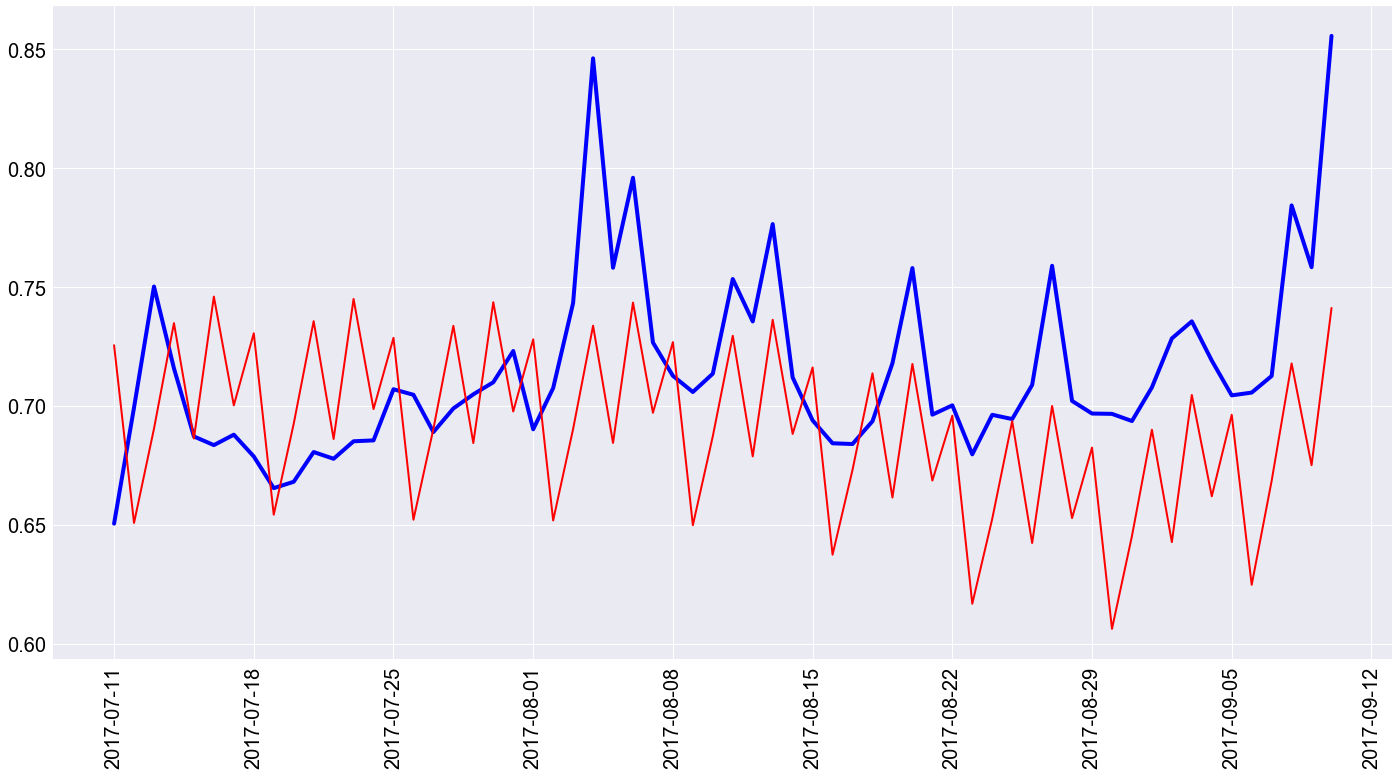

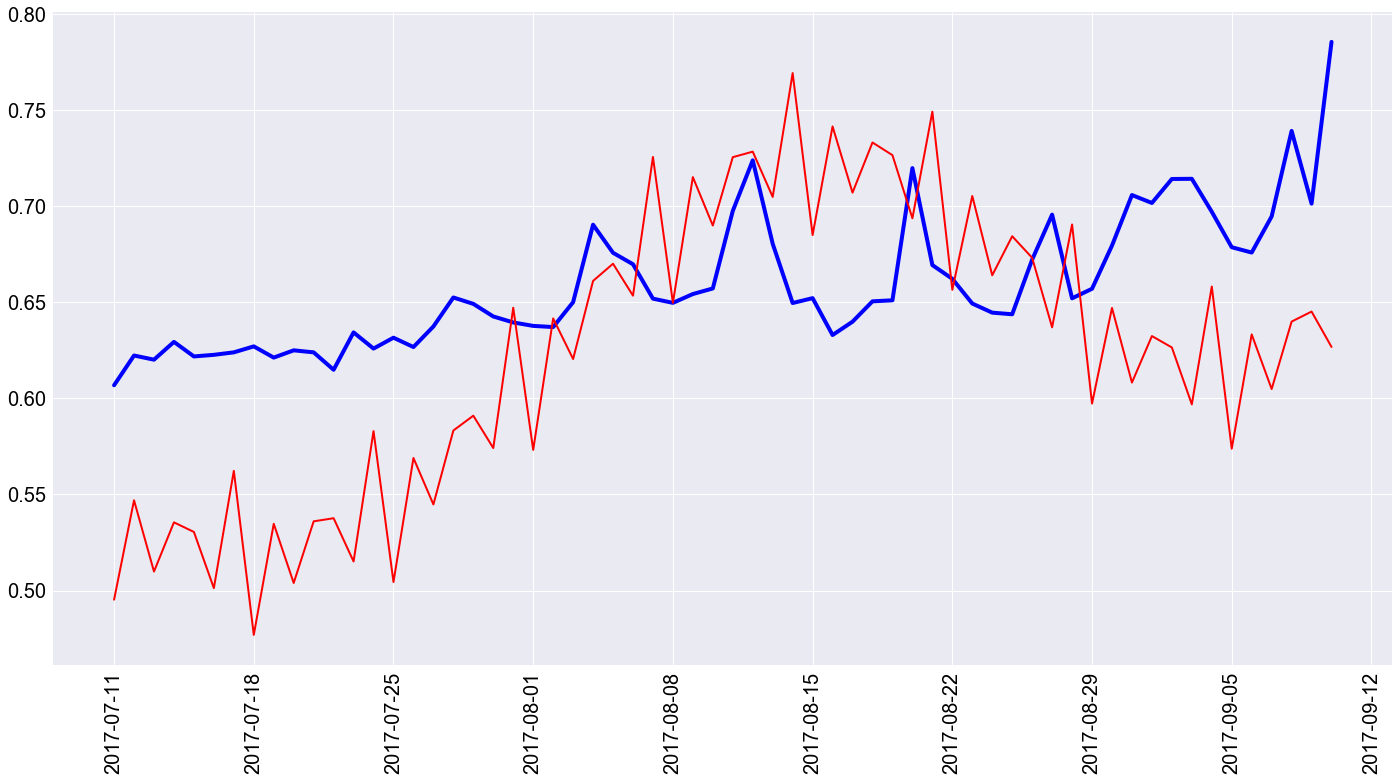

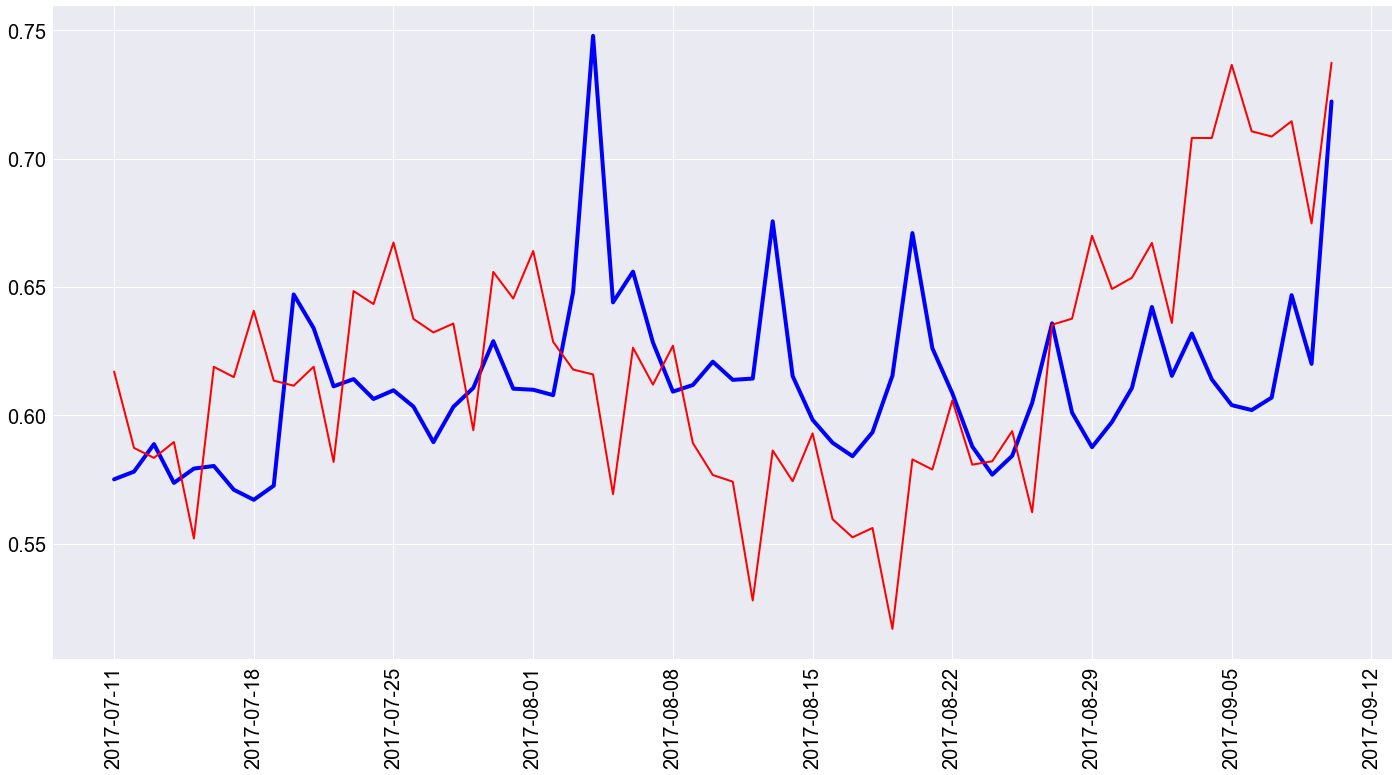

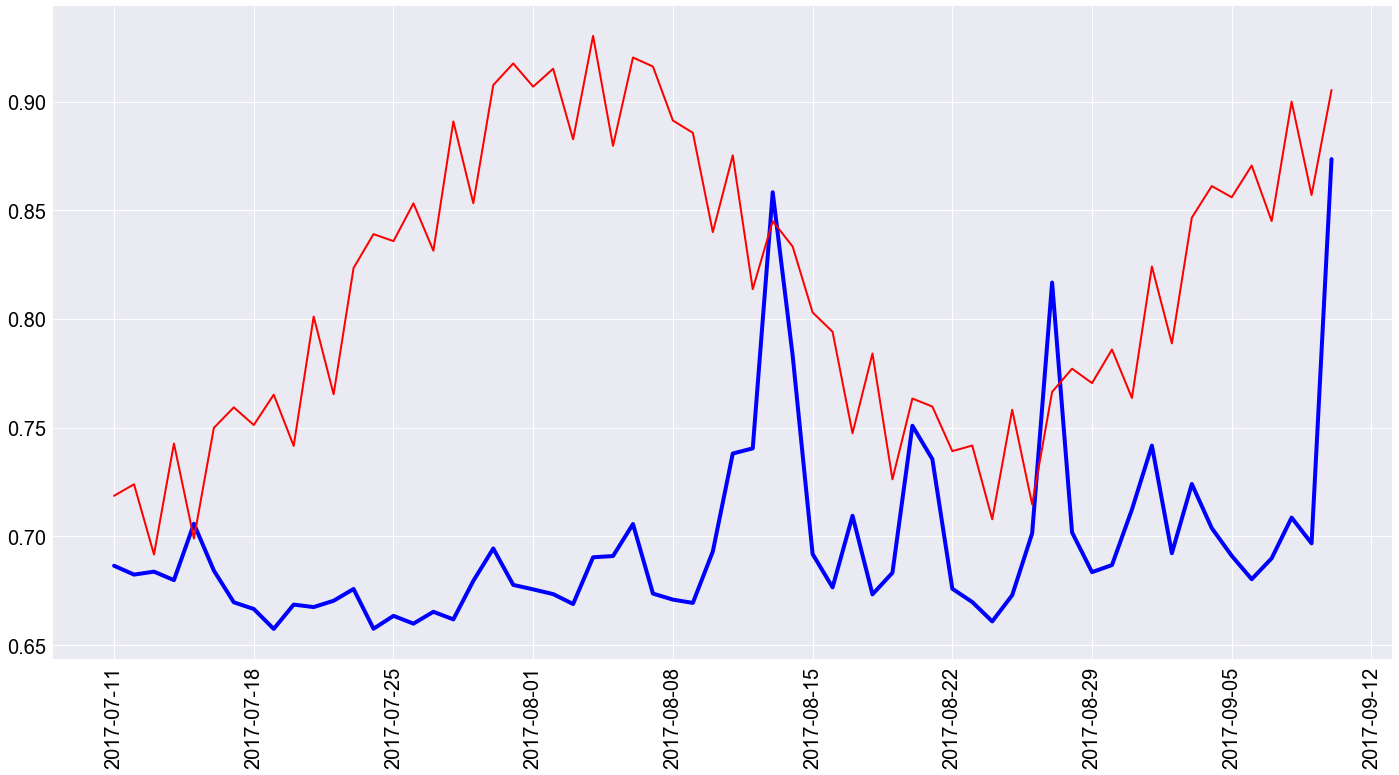

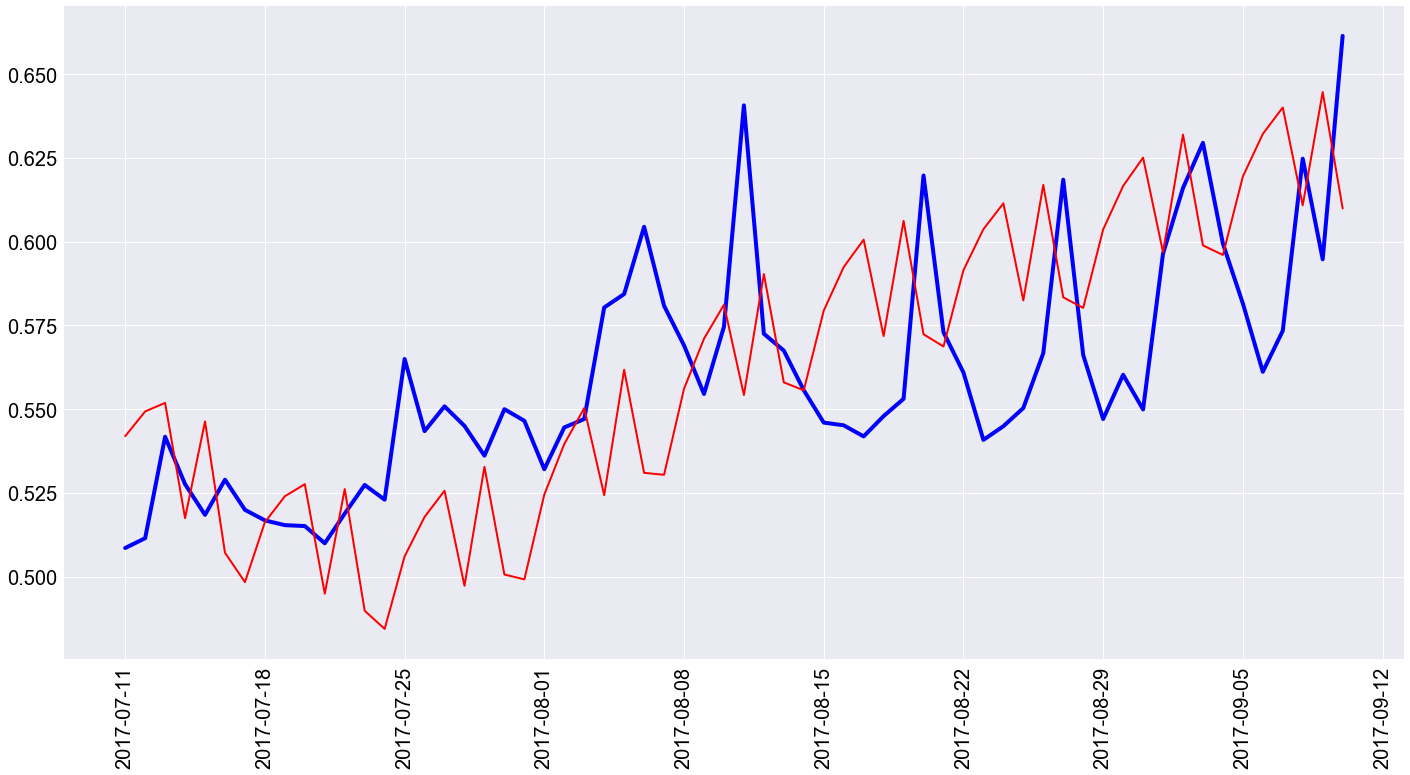

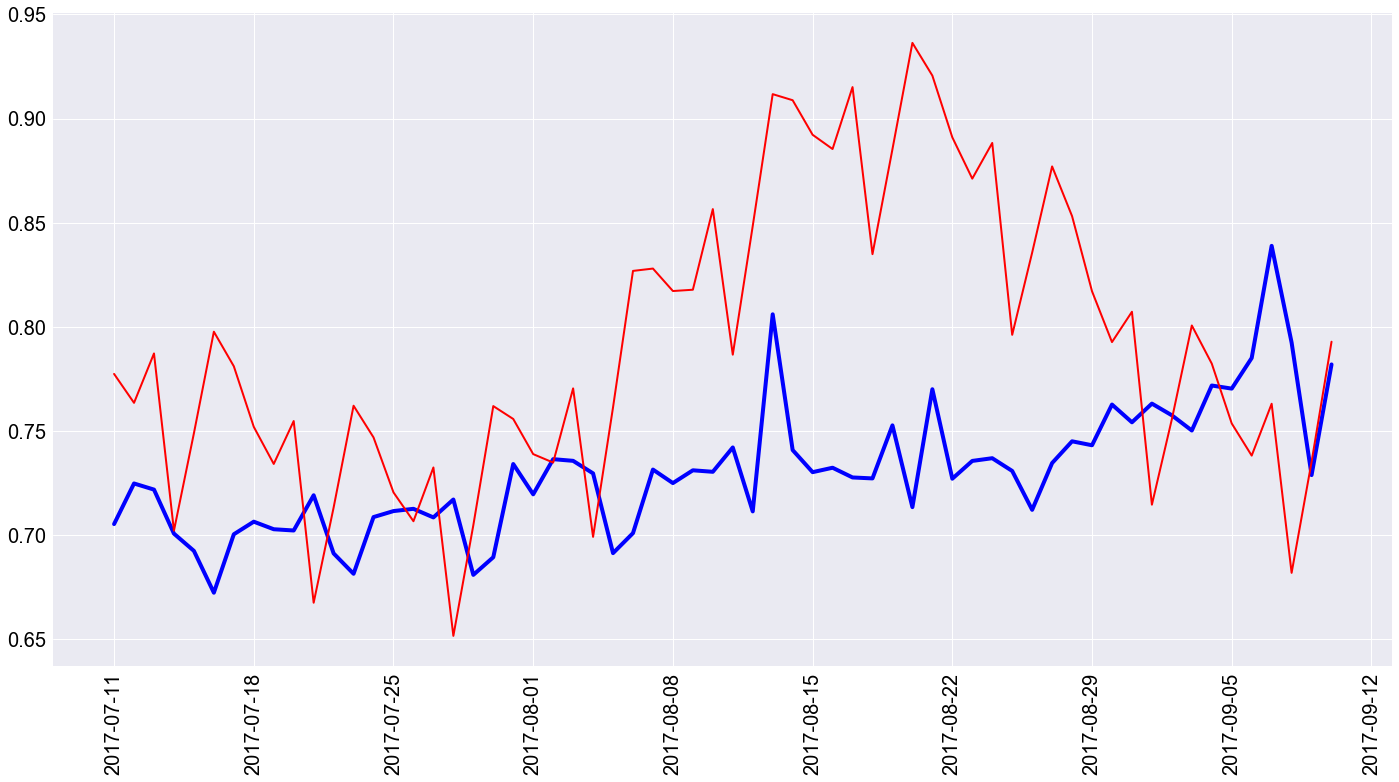

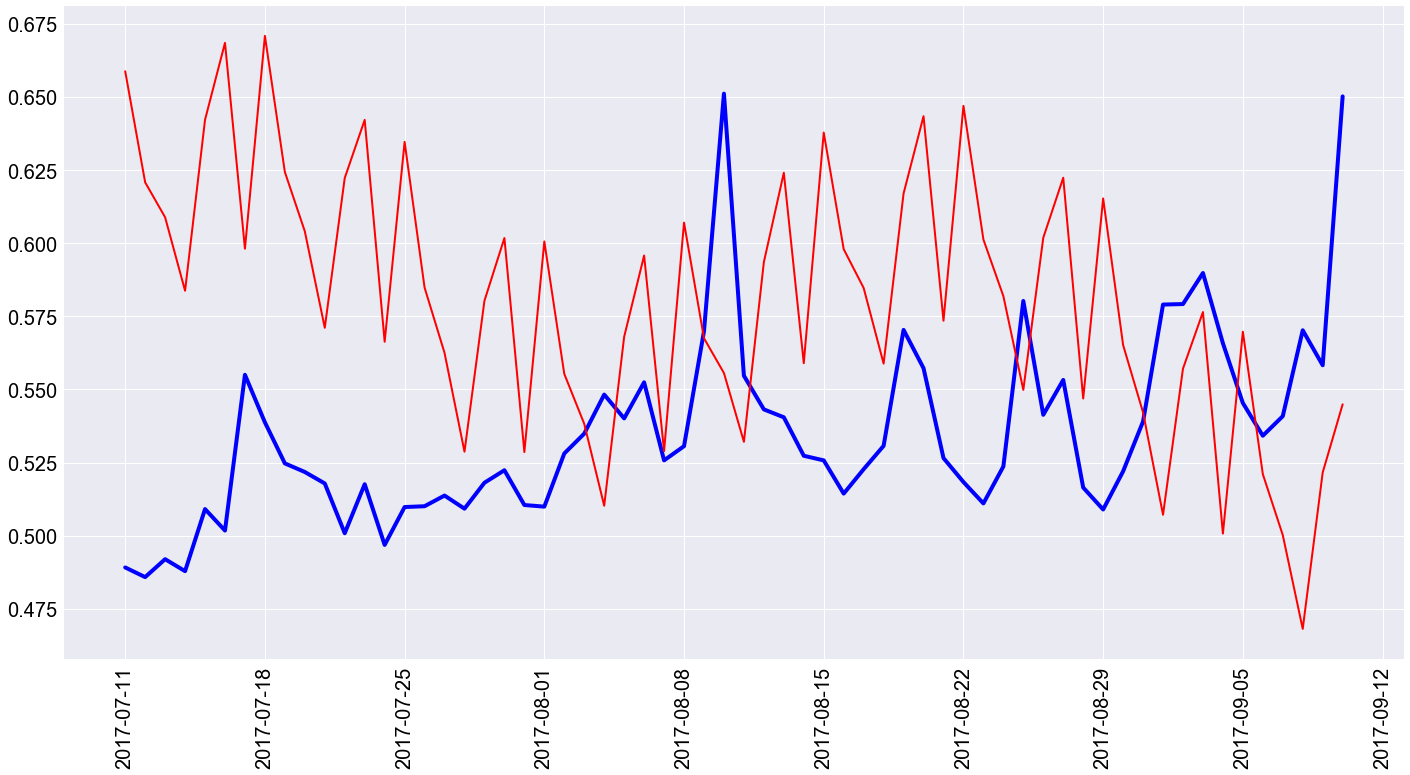

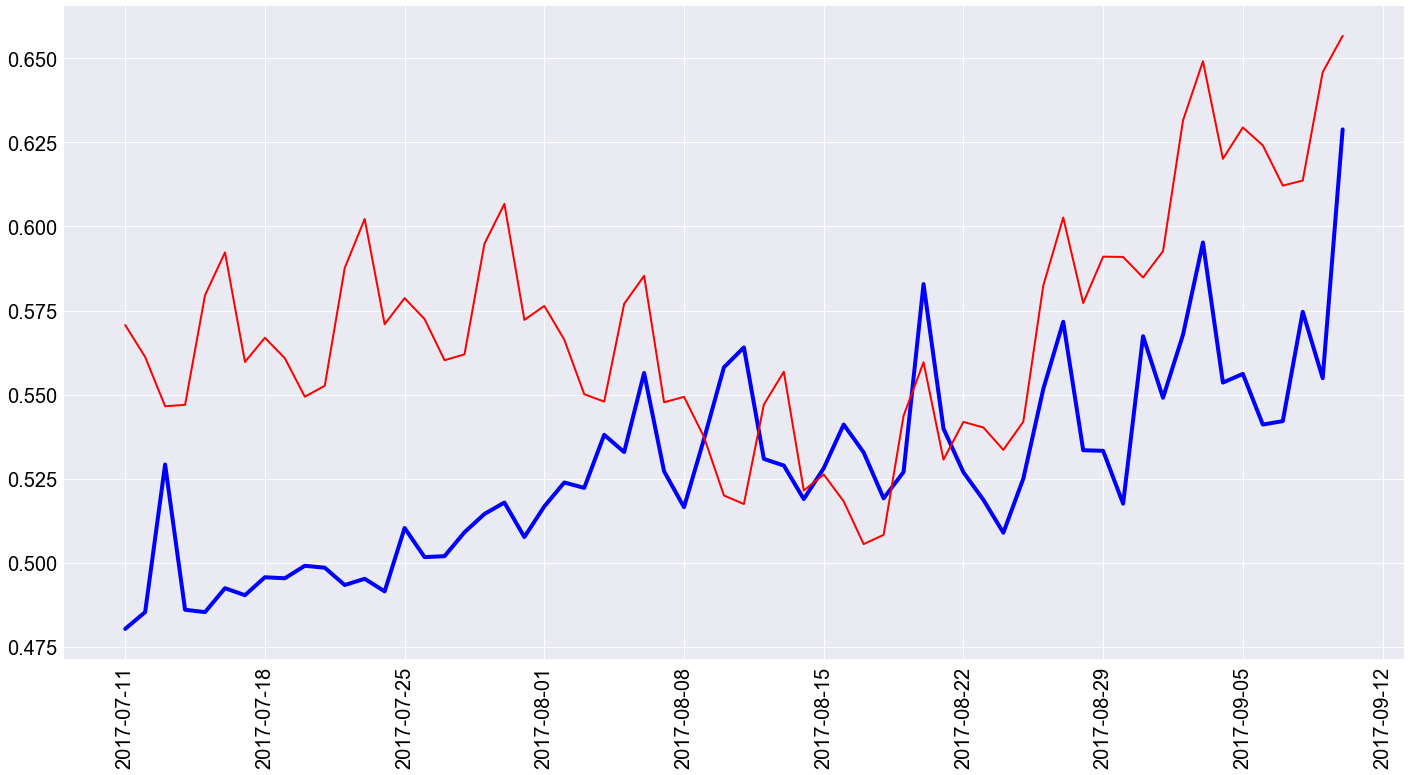

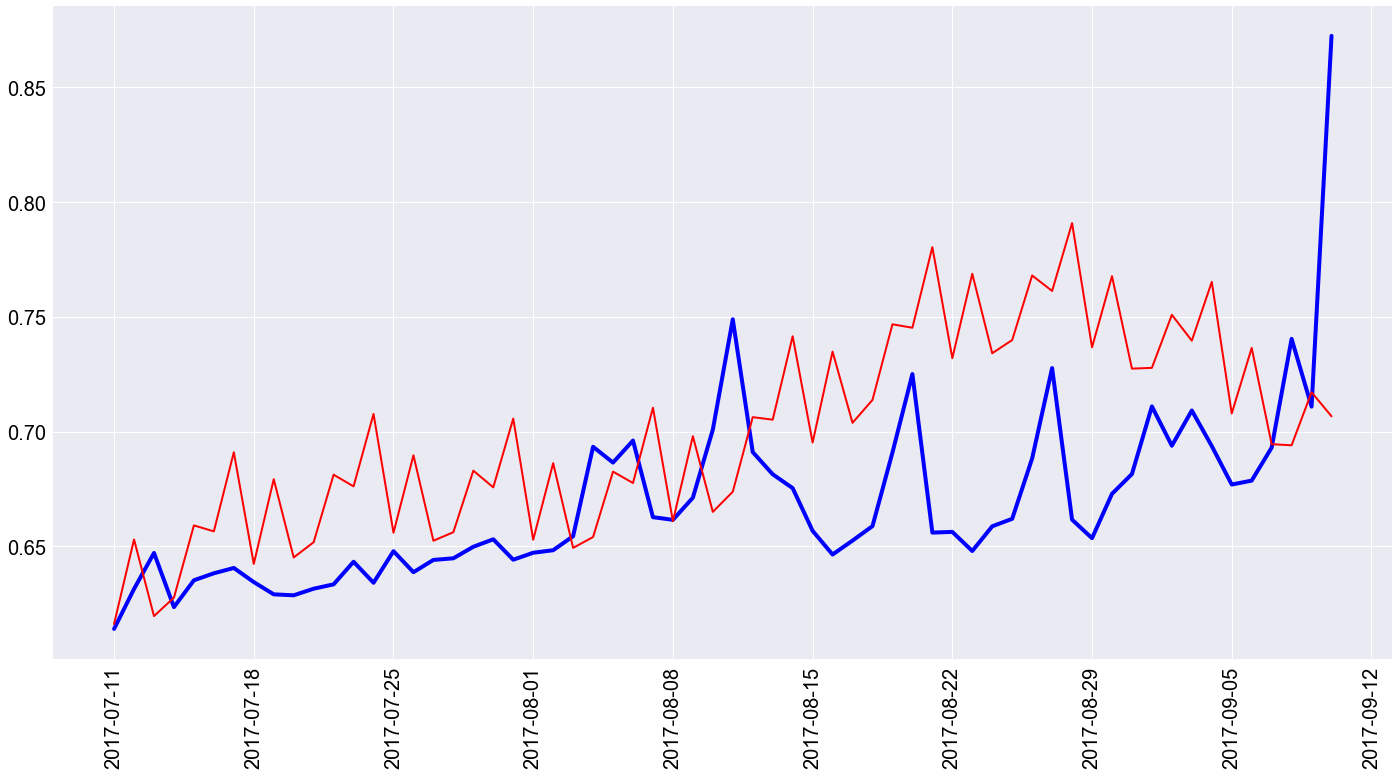

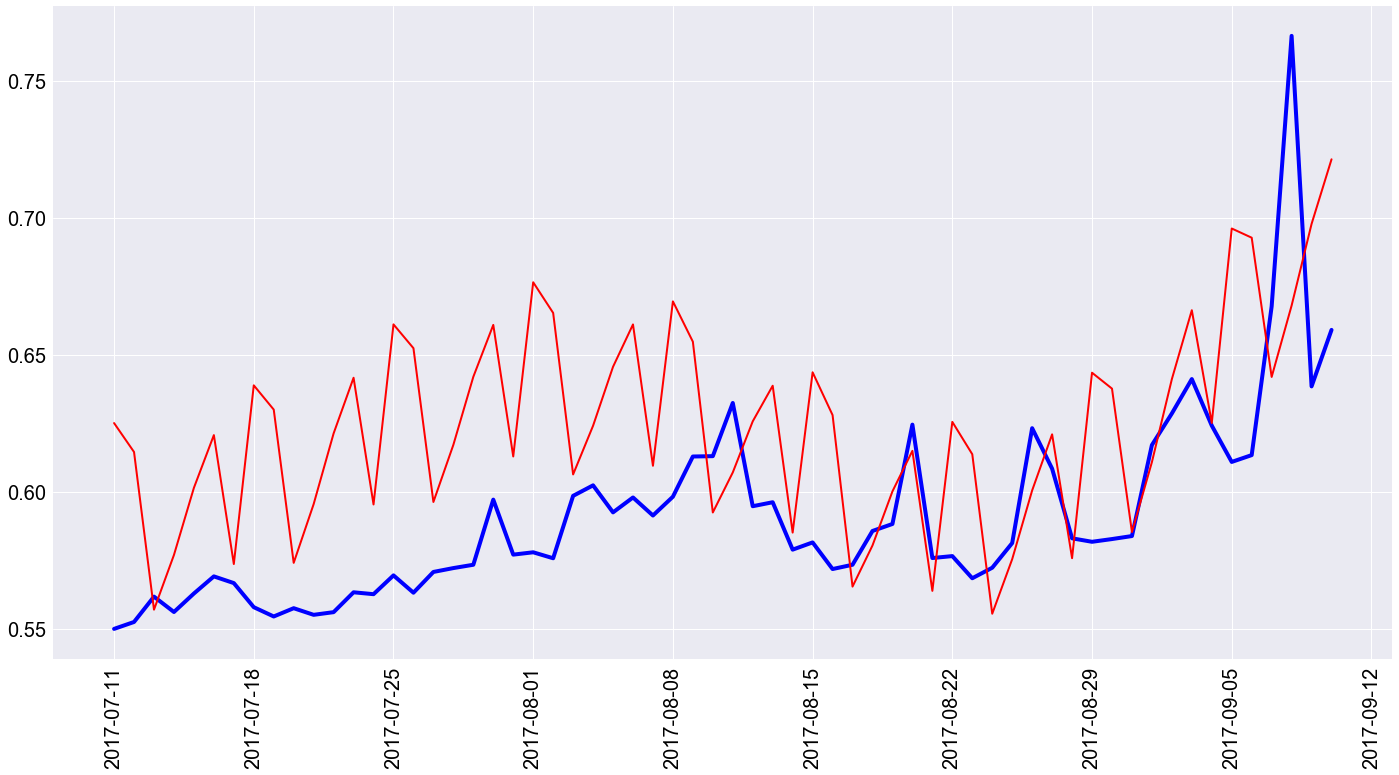

[+] Building model
[+] Running inference
5000/5000 [100%] ██████████████████████████████ Elapsed: 112s | Acceptance Rate: 0.758
[+] Making prediction


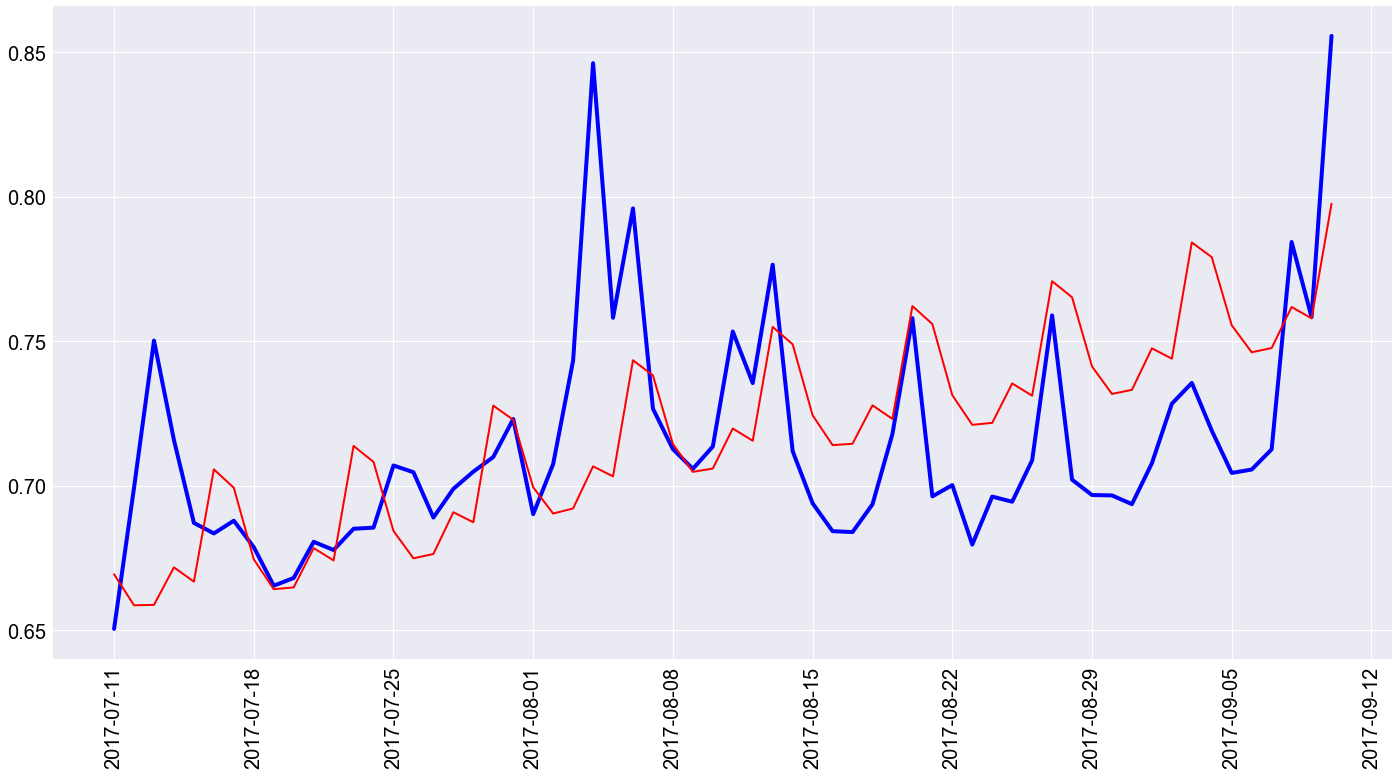

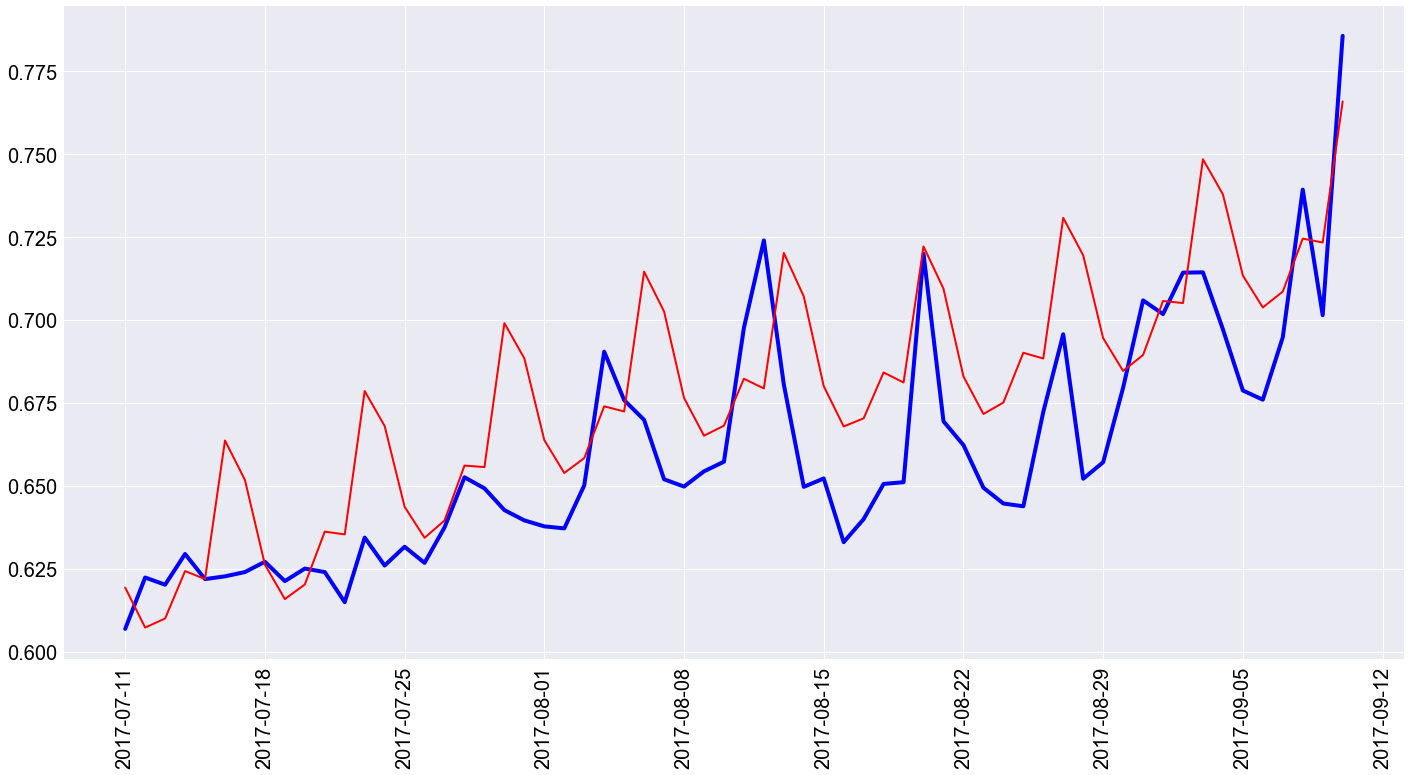

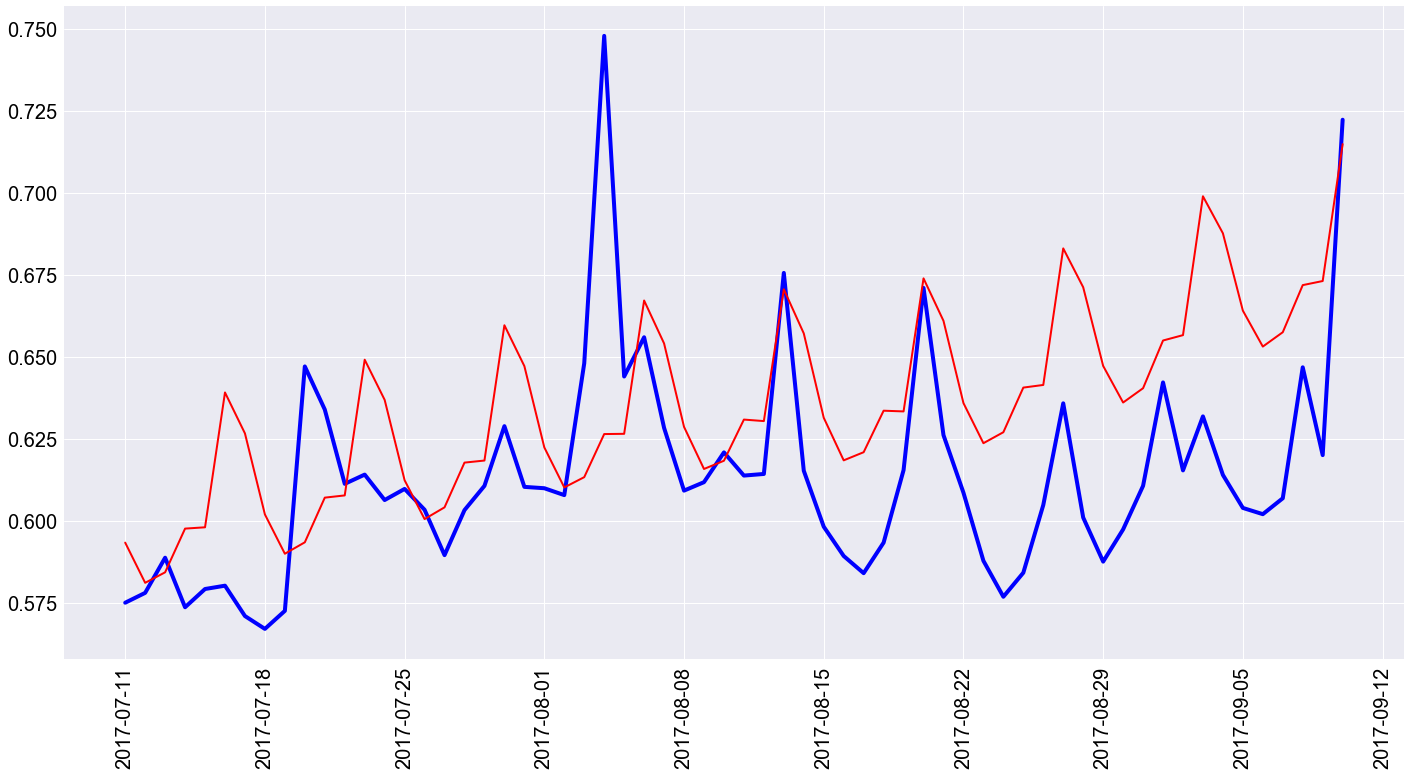

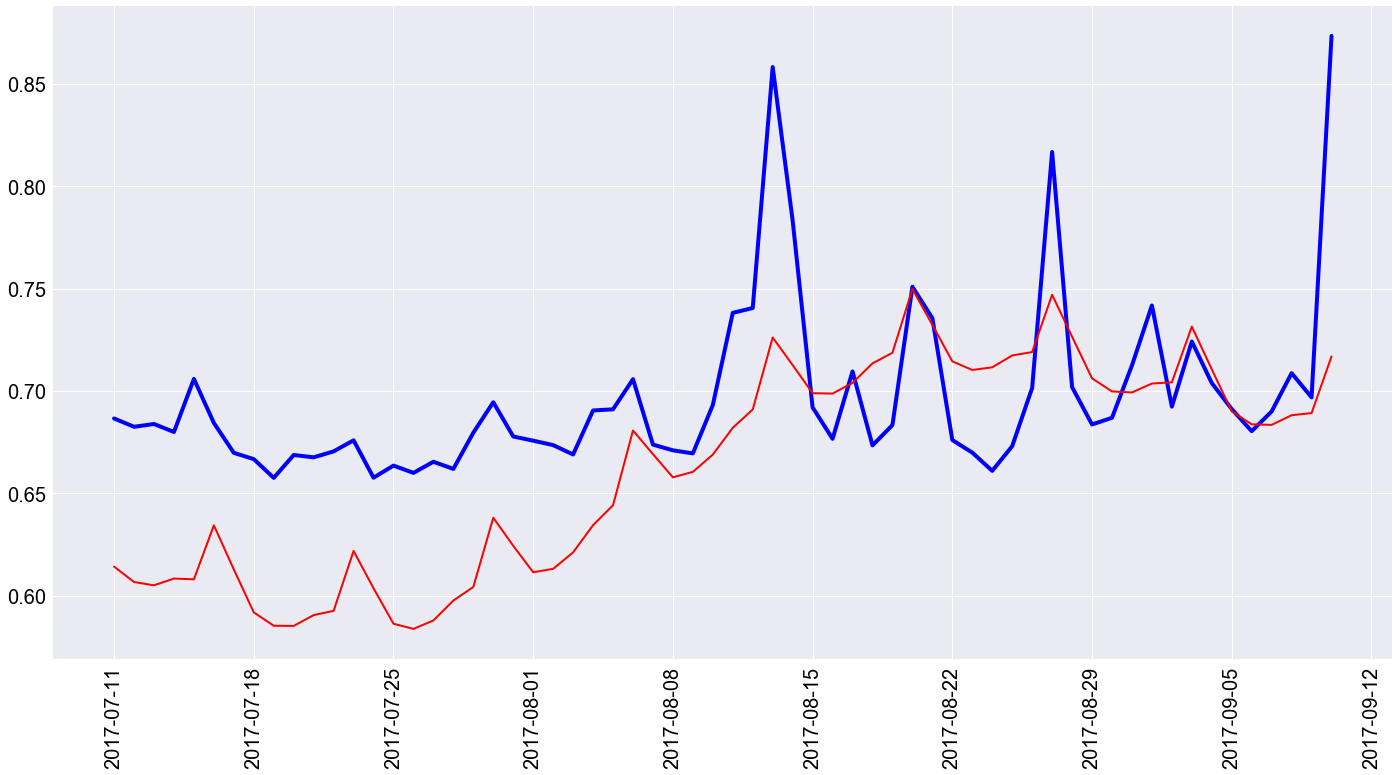

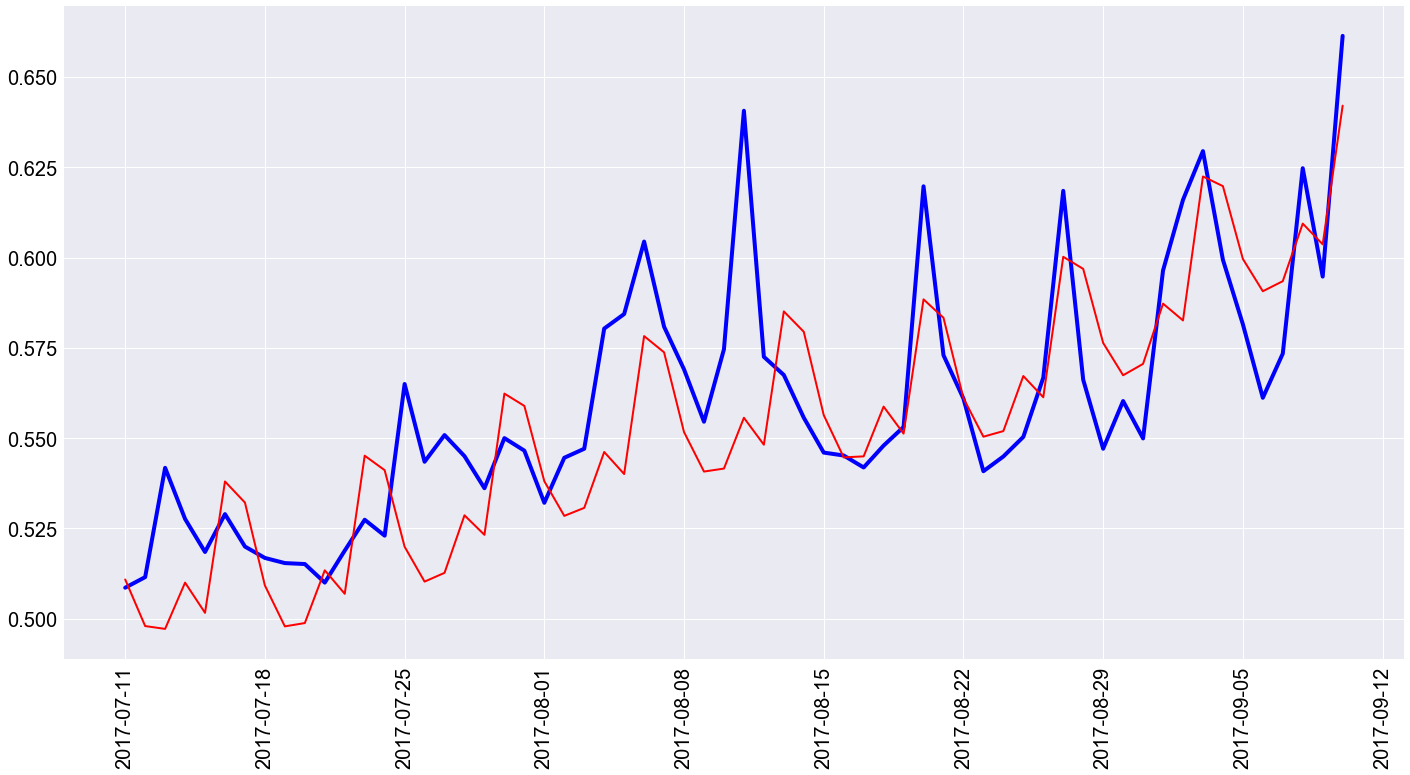

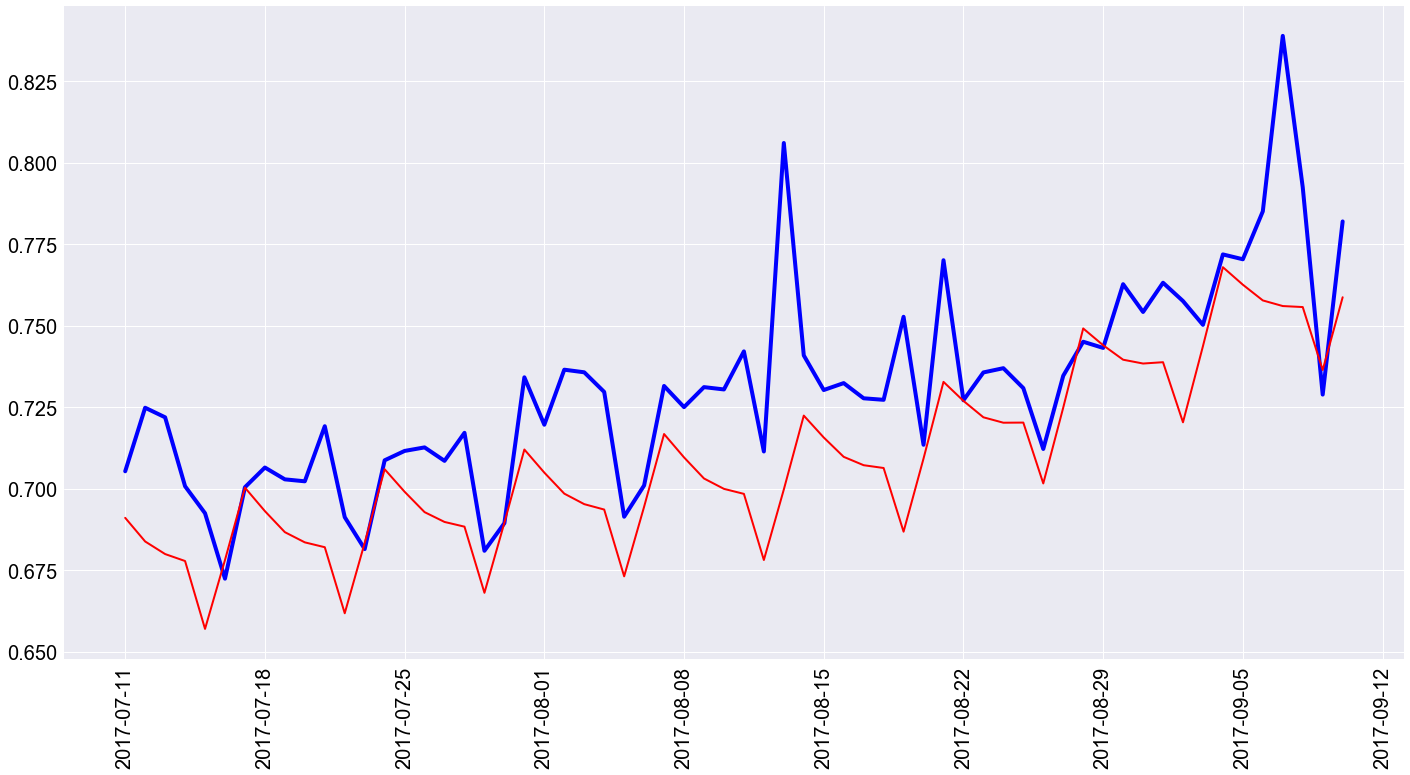

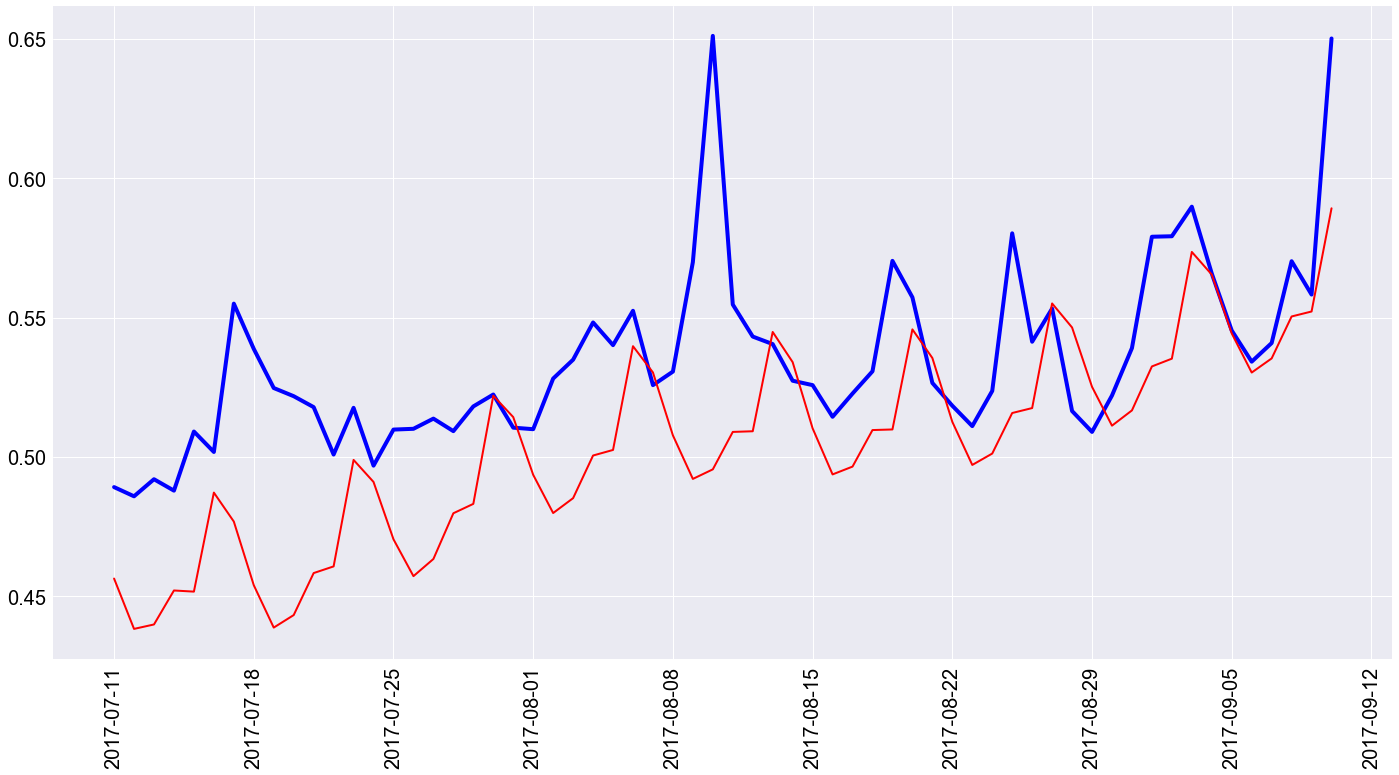

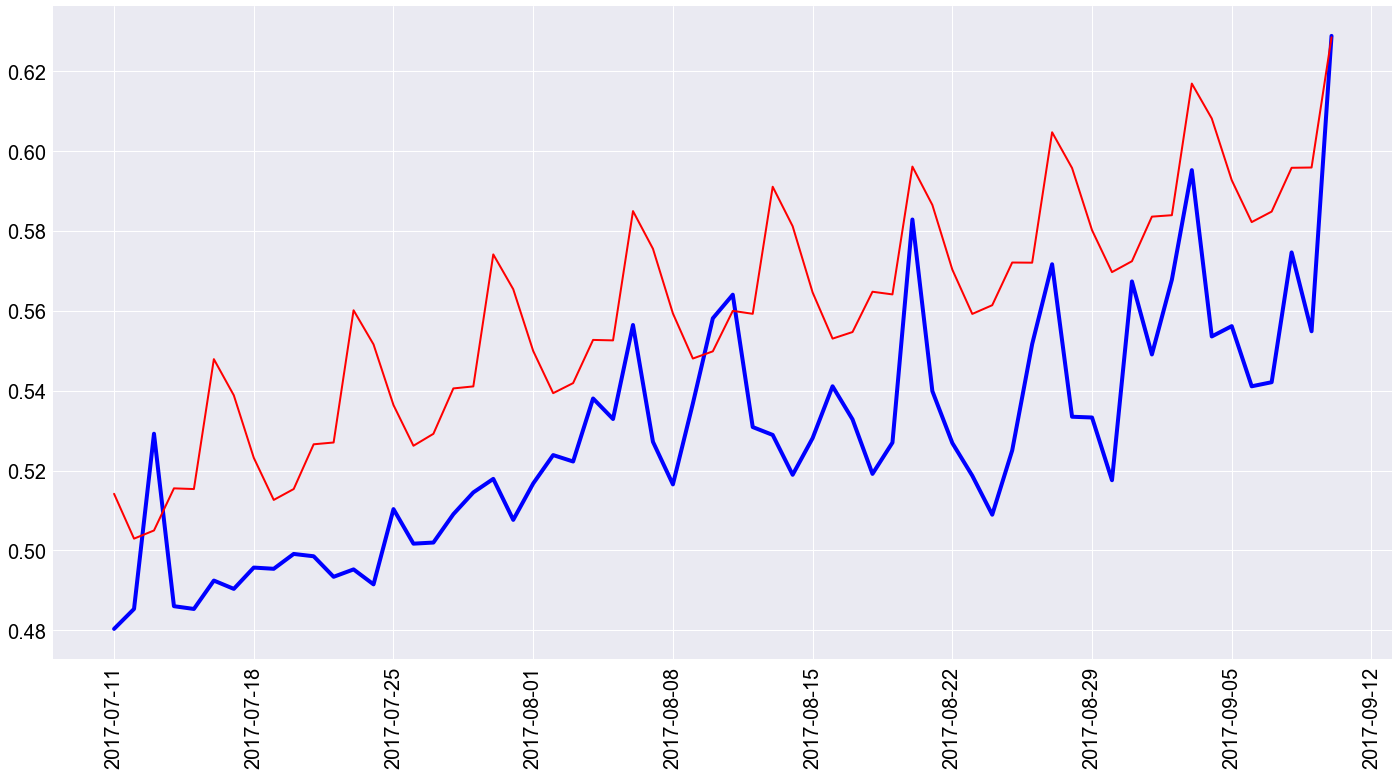

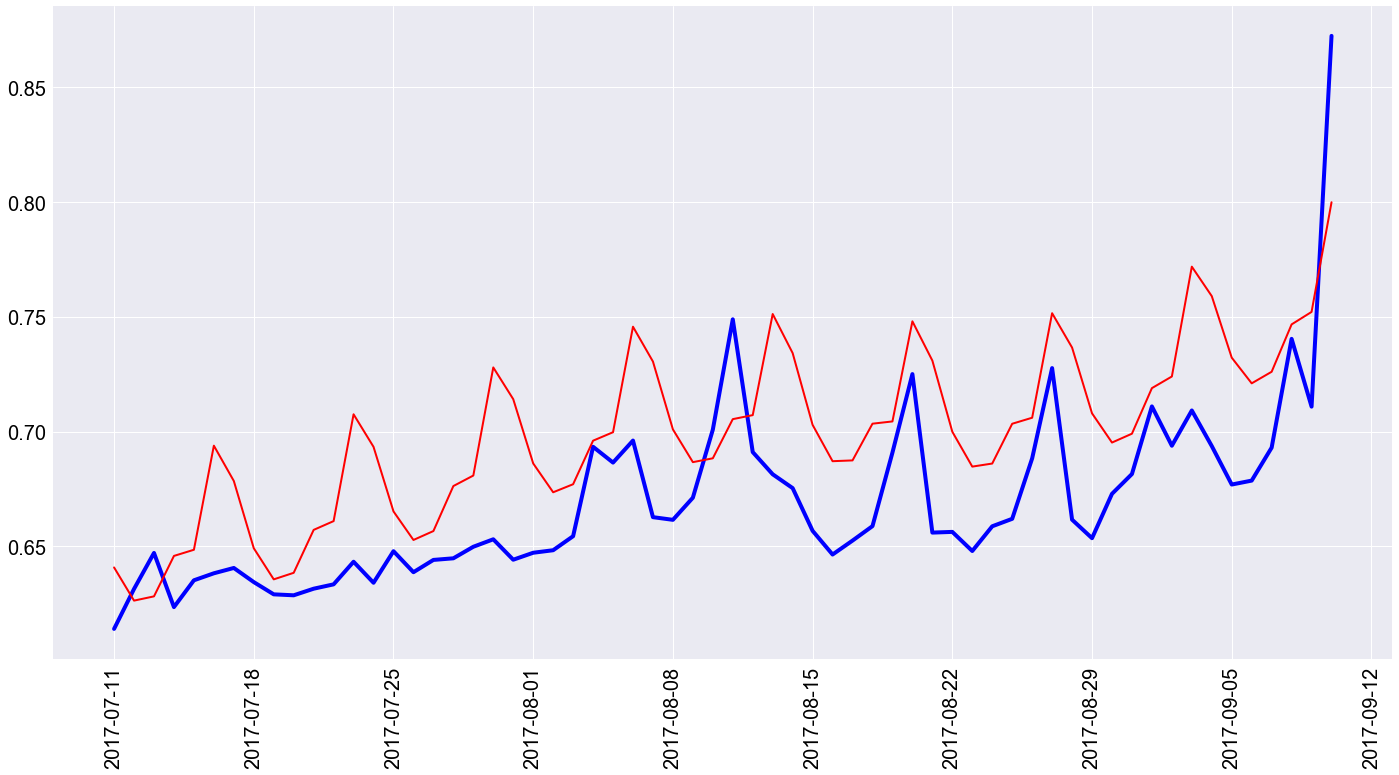

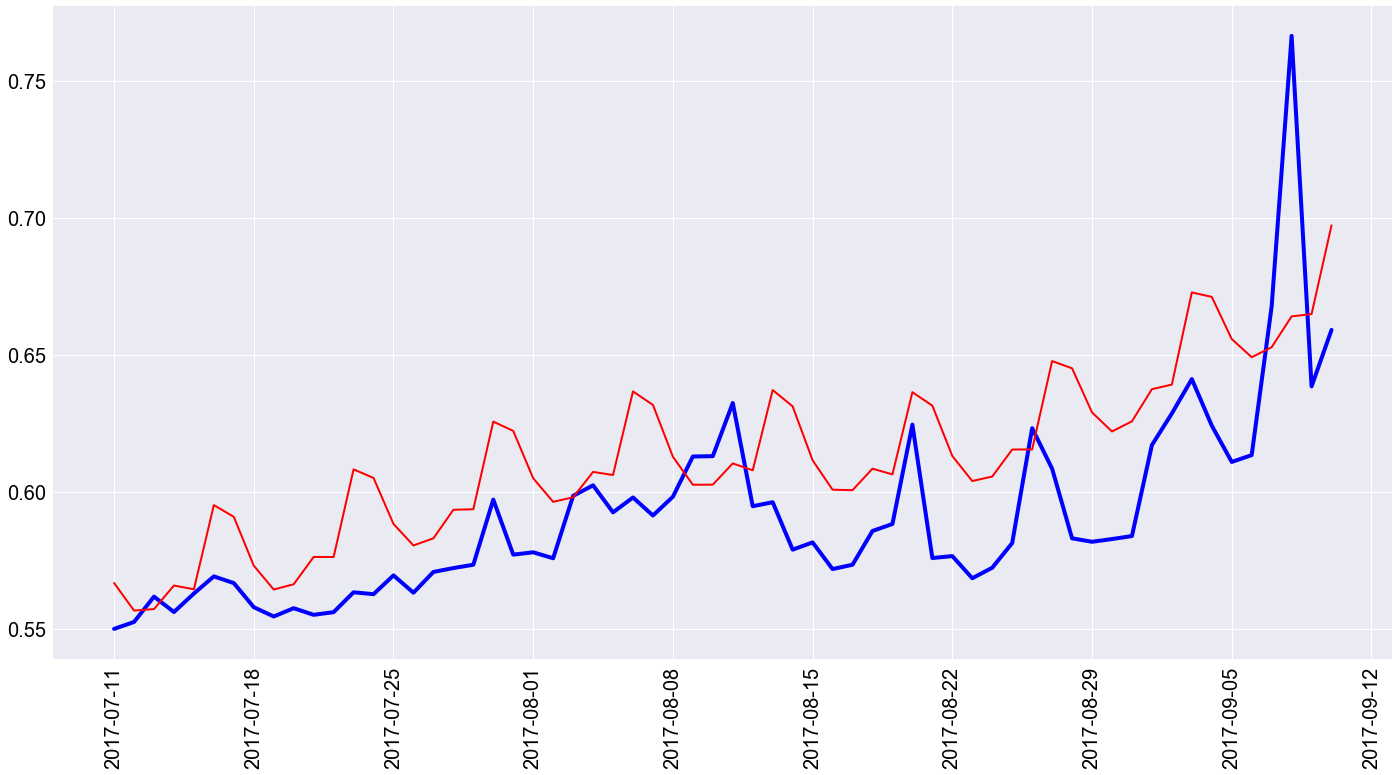

In [19]:
#%%capture
results = []
models_test = [Model1(), Model3(), Model4()]
print("Fitting %d Timeseries" % len(ts_data))
for model in models_test:
    p, m = pipeline(ts_data, model, train_data, test_data, 
                    ITR=5000, N_STEPS=2, STEP_SIZE=5e-4)
    results.append({"predictions": p, "metrics": m})

In [20]:
total_metrics = []
for j, r in enumerate(results):
    m_pd = pd.DataFrame.from_dict(r["metrics"])
    m_pd.loc['mean'] = m_pd.mean()
    total_metrics.append(m_pd)
pd.concat(total_metrics, axis=1)

model1-MAPE  model1-MSE  model1-SMAPE  model3-MAPE  model3-MSE  \
0        6.954919    0.004465      7.190969     5.799429    0.002463   
1        9.853368    0.005475      9.535985    10.024286    0.005839   
2       18.875498    0.016768     18.364915     7.071290    0.002883   
3       13.129795    0.014100     13.755397    17.415547    0.019348   
4       13.097231    0.008554     14.523269     5.718923    0.001546   
5       10.930487    0.009162     10.370638    10.310464    0.008545   
6       18.179654    0.013336     20.657002    12.692367    0.006220   
7       11.338409    0.005707     11.966064     9.213152    0.003070   
8        9.260542    0.006558      9.928106     6.516120    0.003148   
9       11.359678    0.006162     10.753998     7.011196    0.002531   
mean    12.297958    0.009029     12.704634     9.177277    0.005559   

      model3-SMAPE  model4-MAPE  model4-MSE  model4-SMAPE  
0         5.950158     4.008431    0.001418      4.012339  
1        10.497607     3.591709    0.000830      3.510836  
2         7.005213     5.035145    0.001461      4.917765  
3        15.588547     6.551253    0.003169      6.834591  
4         5.689927     3.240252    0.000529      3.284208  
5         9.657951     3.018595    0.000859      3.095313  
6        11.867450     6.101454    0.001884      6.420241  
7         8.699891     6.375808    0.001372      6.136228  
8         6.295435     5.225589    0.001654      5.067753  
9         6.705192     4.503147    0.001025      4.402746  
mean      8.795737     4.765138    0.001420      4.768202

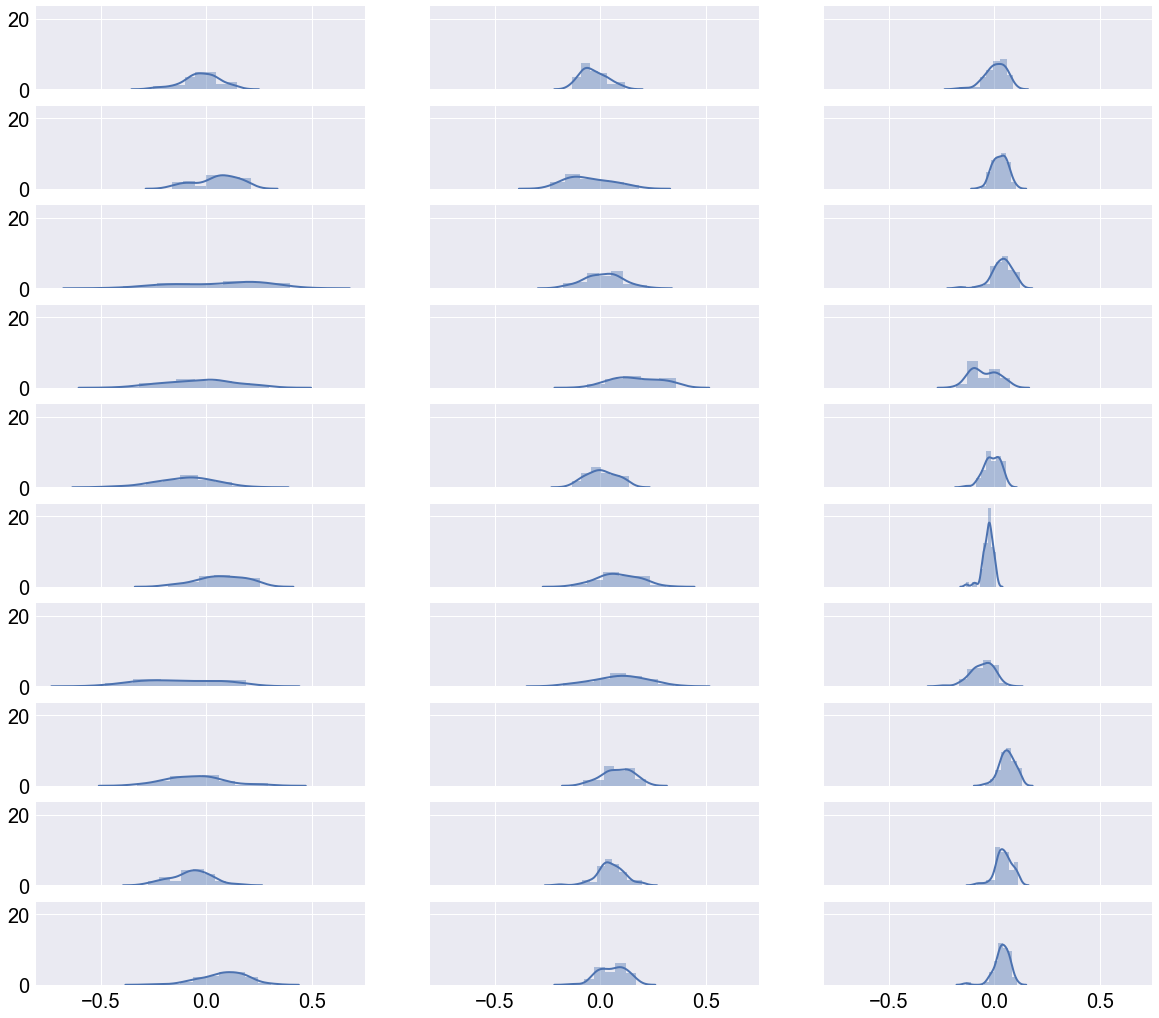

In [21]:
# residual
fig, axes = plt.subplots(len(ts_data), len(results), figsize=(20,18),
                         sharex=True, sharey=True)      
for j, r in enumerate(results):
    for i, ts in enumerate(ts_data):
        resids = (r["predictions"][i]["y"].as_matrix() - ts["future"]["y_scaled"].as_matrix()) \
                 / ts["future"]["y_scaled"].as_matrix()
        sns.distplot(resids, ax = axes[i, j])
plt.show()


In [22]:
# Fit Training 
results_train = []
for model in models_test:
    predictions = []
    metrics = []
    for i, ts in enumerate(ts_data):
        df = pd.DataFrame({"ds": ts["history"]["ds"].copy(),
                           "t": ts["history"]["t"].copy()})
        df.reset_index(inplace=True, drop=True)
        df = predict_fixed(df, model.post_params[i], train_data)
        predictions.append(df)
        y_true = ts["history"]["y_scaled"].as_matrix()
        metrics.append(evaluate(y_true, df["y"]))
            
    results_train.append({
        "predictions": predictions, 
        "metrics": metrics,
    })

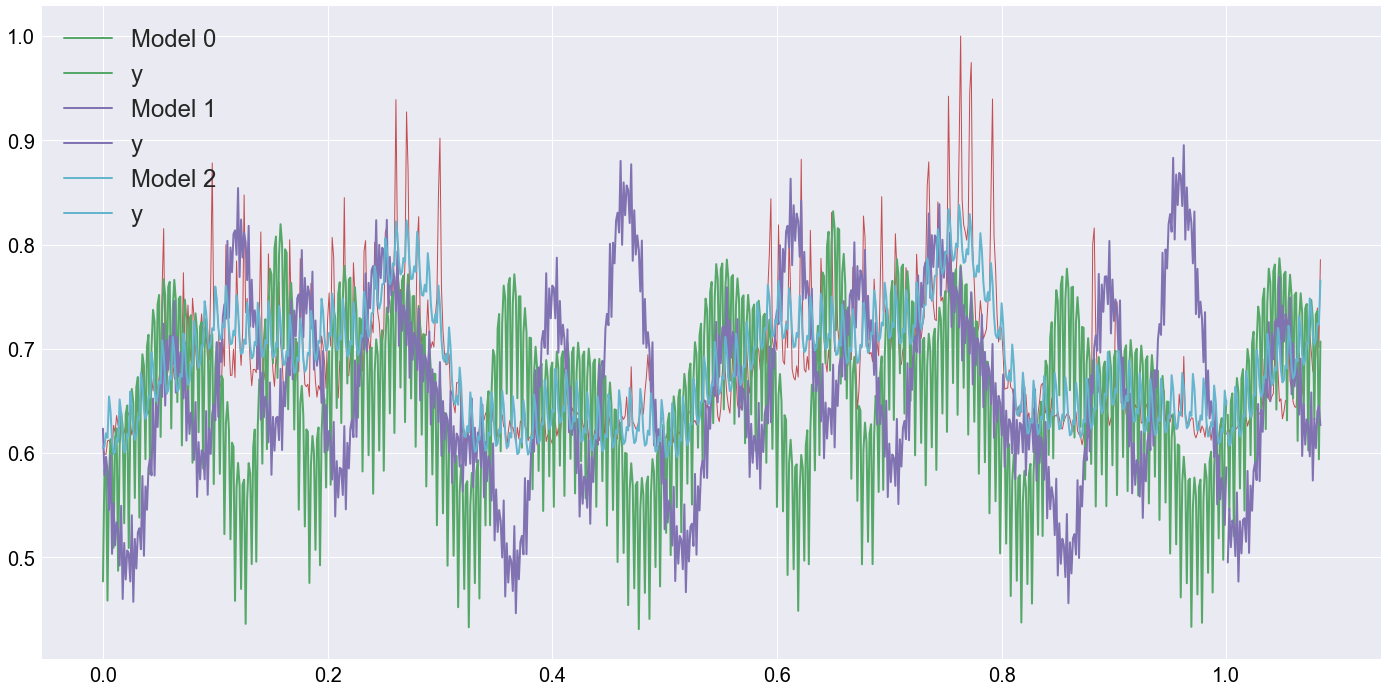

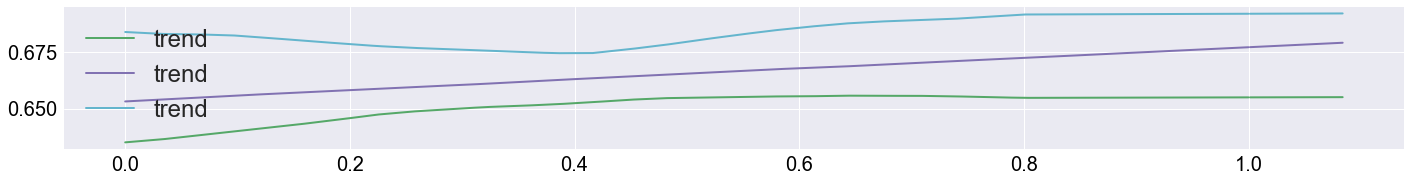

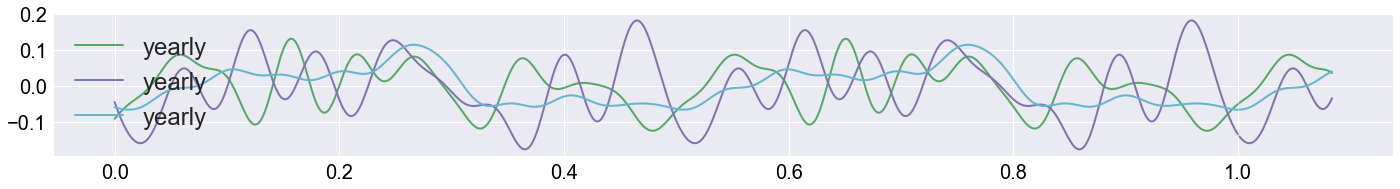

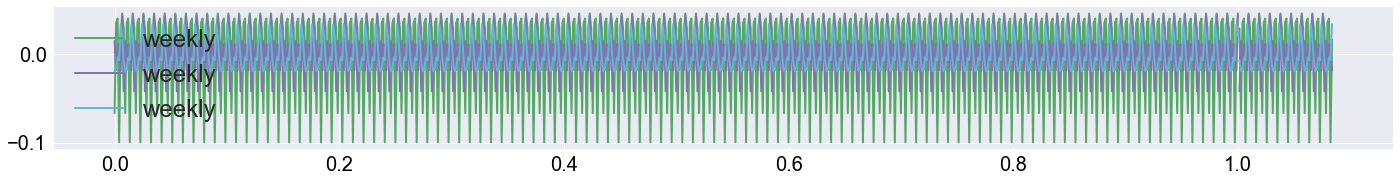

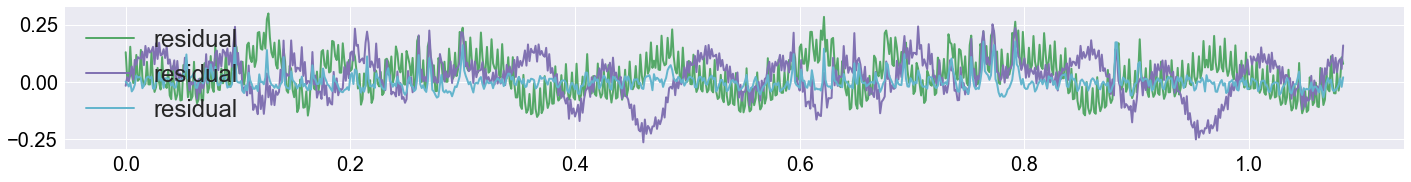

In [23]:
visualize_results(results, results_train, ts_data, ts_idx=1)

## 2. Criticism -- Model1 vs Model4 (k)

model1
TS 0: -0.011304, 0.004134
TS 1: 0.040885, 0.011054
TS 2: 0.020904, 0.004390
TS 3: 0.298673, 0.004310
TS 4: 0.061565, 0.008151
TS 5: 0.018074, 0.004923
TS 6: 0.050233, 0.006190
TS 7: 0.022195, 0.008049
TS 8: -0.034903, 0.004122
TS 9: 0.035421, 0.003237


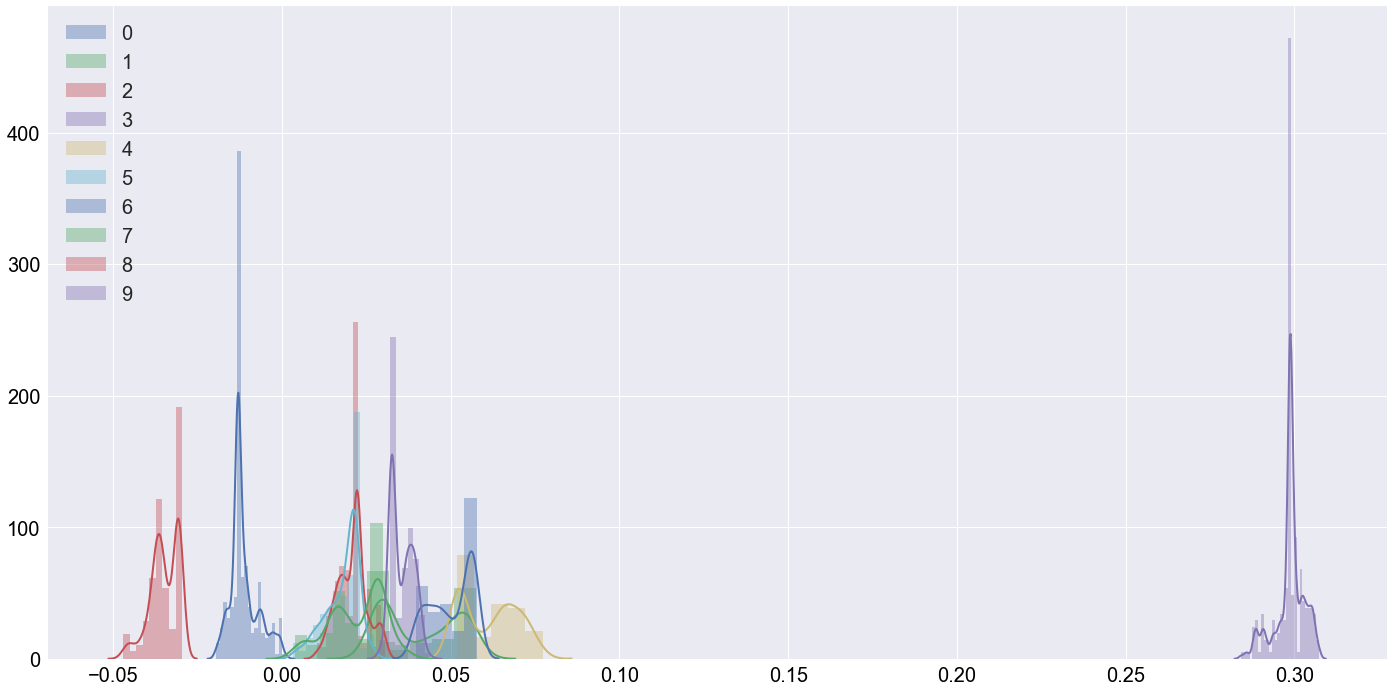

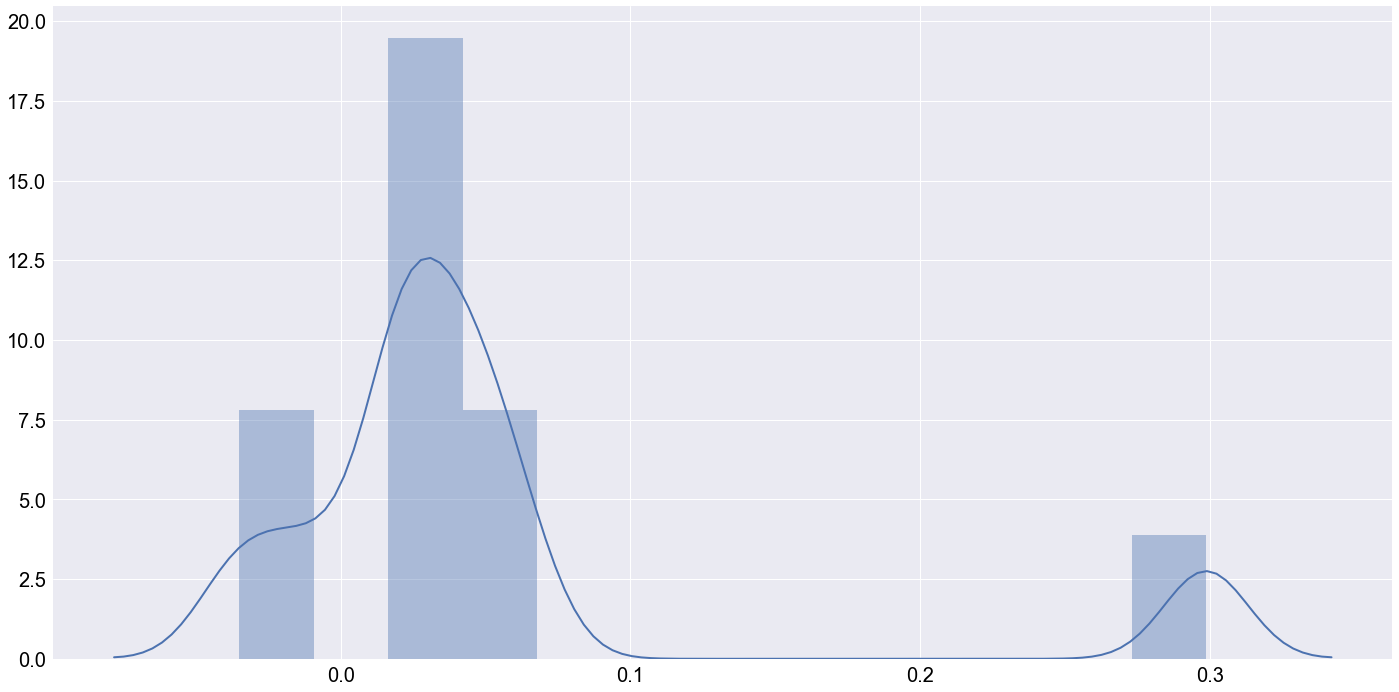

model4
TS 0: 0.003541, 0.007107
TS 1: -0.026157, 0.036227
TS 2: 0.065406, 0.009316
TS 3: 0.573763, 0.056065
TS 4: 0.125486, 0.020523
TS 5: 0.013282, 0.031697
TS 6: 0.030975, 0.010505
TS 7: -0.048273, 0.028191
TS 8: -0.015569, 0.024125
TS 9: 0.004482, 0.008007


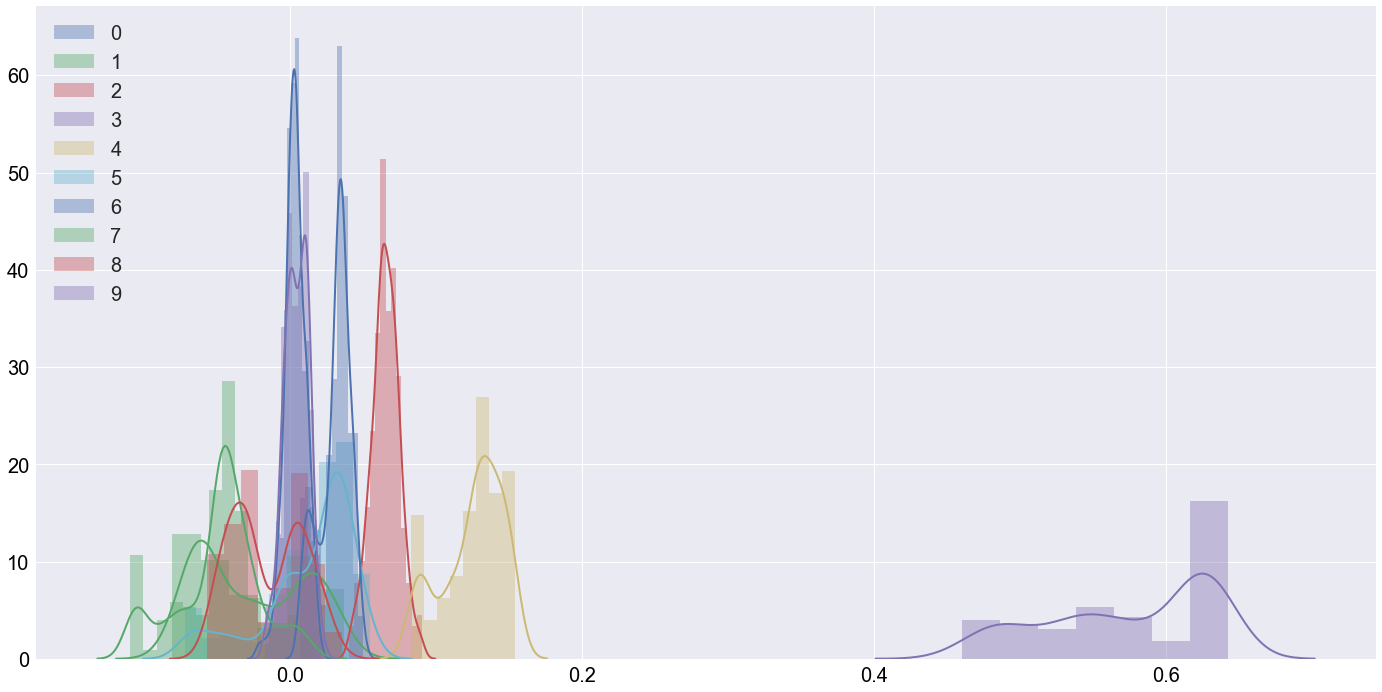

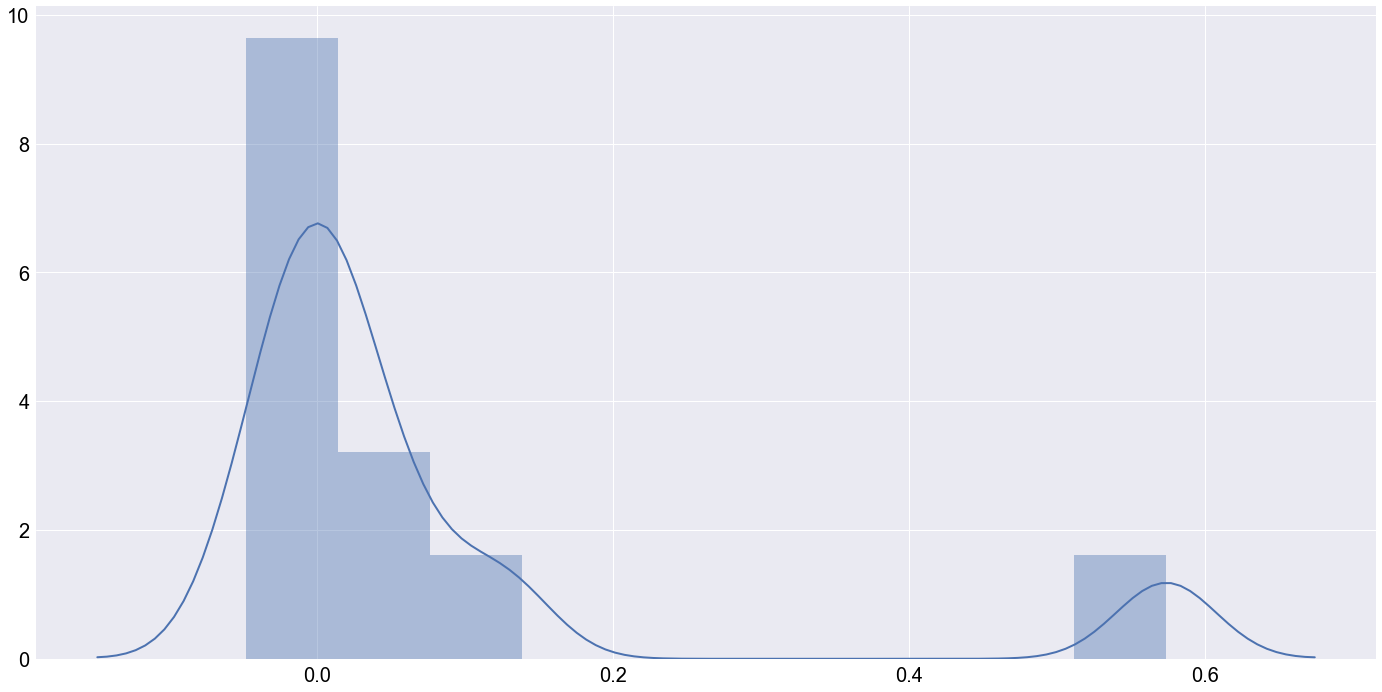

In [24]:
# Model 1
for m, model in enumerate([models_test[0], models_test[2]]):
    print(model.name)
    for i, ts in enumerate(ts_data):
        sns.distplot(model.post_params[i]["k"], label=str(i))
        print("TS %d: %f, %f" % (i, np.mean(model.post_params[i]["k"]), 
                                 np.std(model.post_params[i]["k"])))
    plt.legend(loc=2, fontsize=20)
    plt.show()
    sns.distplot([np.mean(model.post_params[i]["k"]) for i in range(len(ts_data))])
    plt.legend(loc=2, fontsize=20)
    plt.show()

# for m, model in enumerate(models_test[0]):
#     print("Model %d" % m)
#     for i, ts in enumerate(ts_data[1:2]):
#         for beta in model.post_params[i]["beta"]:
#             plt.plot(beta, 'o')
#         plt.show()
   
    

In [25]:
# cs = ['C1', 'C3', 'C5']
# for j, r in enumerate(results):
#     for i, ts in enumerate(ts_data):
#         df = r["predictions"][i]
#         #print(df["trend"].head())
#         #print(df["trend"].iloc[0])
#         plt.plot(ts["future"]["t"], df["trend"] - np.ones(df["trend"].shape[0]) * df["trend"].iloc[0], color=cs[j],
#                 label=str(j))
# plt.legend(loc=2, prop={'size': 24})
# plt.show()

    

In [26]:
results[1]["predictions"][0].head()
results_train[1]["predictions"][0].tail()
#ts_data[0]["history"].tail()

ds         t     trend  seasonal  seasonal_lower  seasonal_upper  \
736 2017-07-06  0.994595  0.715389 -0.039495       -0.075917       -0.005144   
737 2017-07-07  0.995946  0.715418  0.006872       -0.061716        0.066228   
738 2017-07-08  0.997297  0.715447 -0.039766       -0.071774       -0.013342   
739 2017-07-09  0.998649  0.715477  0.021881       -0.027321        0.060783   
740 2017-07-10  1.000000  0.715506 -0.022076       -0.038263        0.004426   

       weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
736 -0.014020     -0.018629     -0.008483 -0.025475     -0.060699   
737  0.029470     -0.004129      0.059092 -0.022598     -0.059369   
738 -0.019788     -0.028205     -0.009712 -0.019978     -0.057192   
739  0.039515      0.027145      0.051429 -0.017633     -0.055774   
740 -0.006500     -0.029468      0.022922 -0.015576     -0.054621   

     yearly_upper         y  
736      0.008382  0.675894  
737      0.011763  0.722290  
738      0.016045  0.675681  
739      0.018597  0.737358  
740      0.020026  0.693430

## 2. Criticism -- Model1 vs Model3

model1


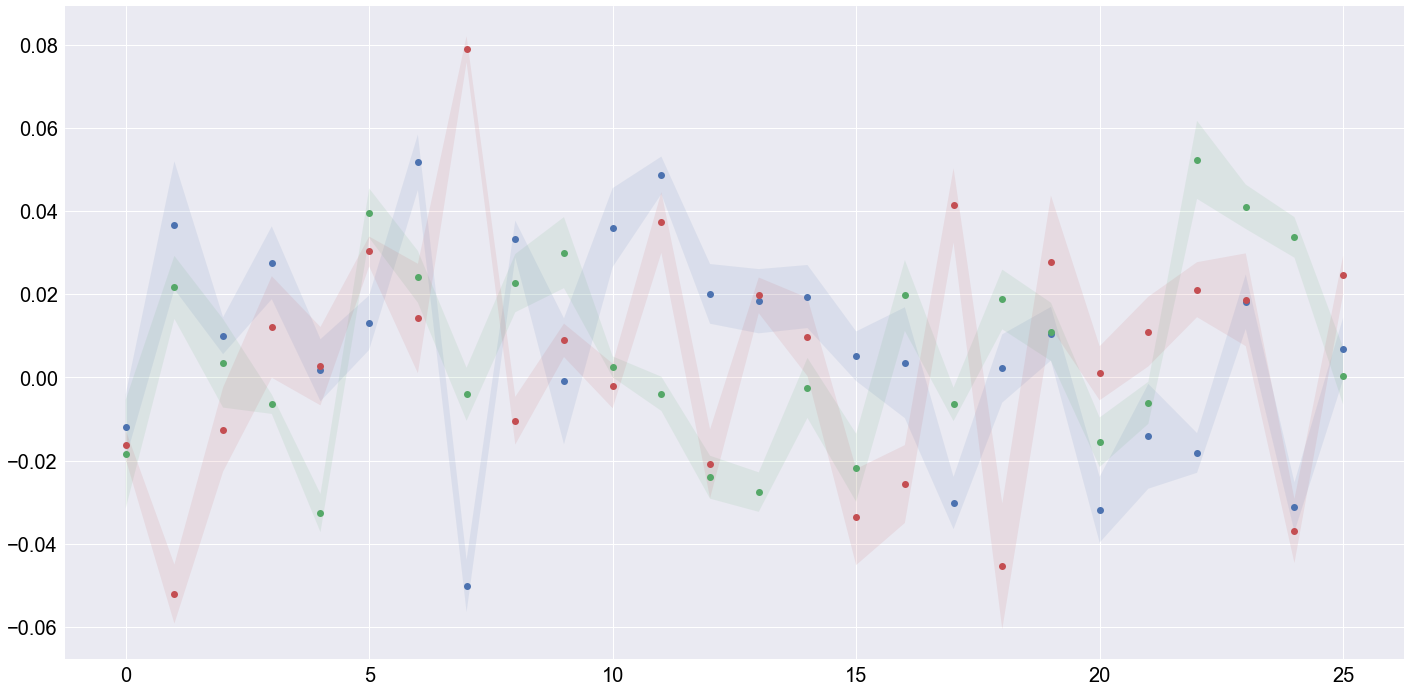

model3


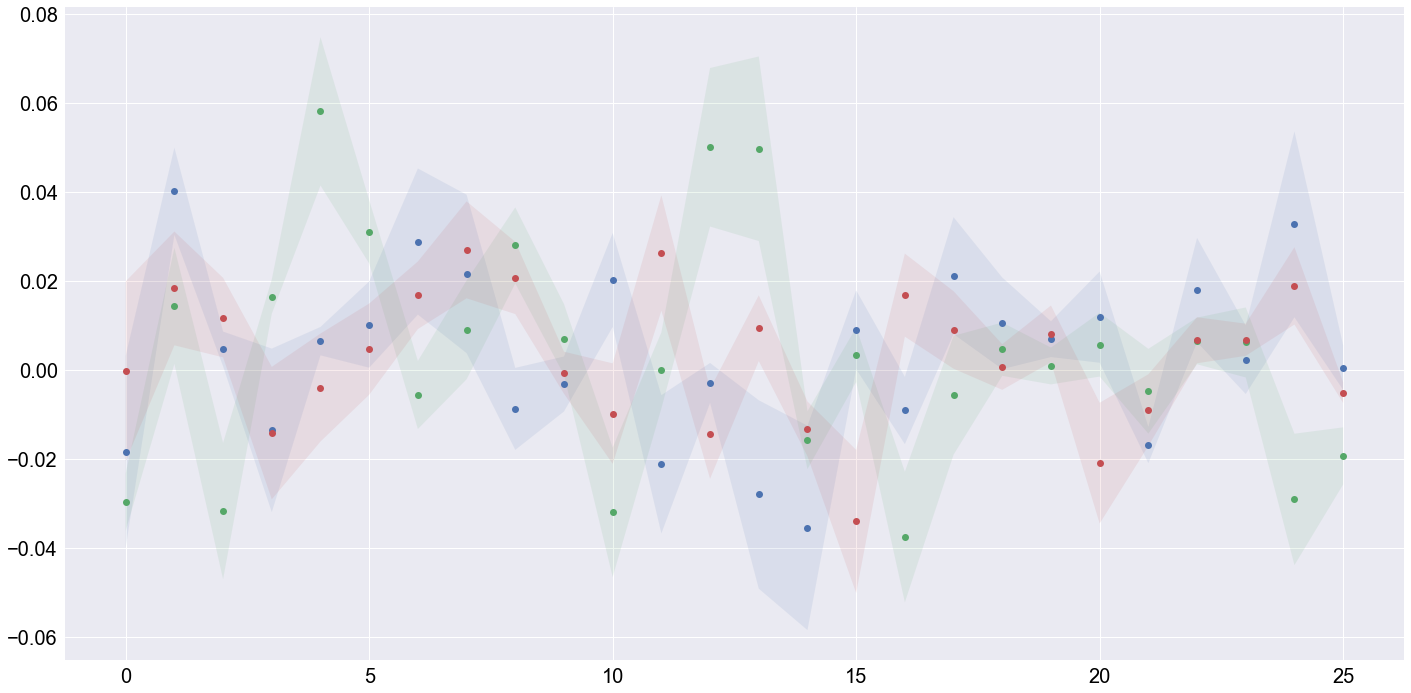

In [27]:
for m, model in enumerate([models_test[0], models_test[1]]):
    print(model.name)
    nbeta = len(model.post_params[i]["beta"][0])
    for i, ts in enumerate(ts_data[:3]):
        #print("TS %d" % i)
        beta_mean = np.mean(model.post_params[i]["beta"], axis=0)
        beta_std = np.std(model.post_params[i]["beta"], axis=0)
        plt.plot(beta_mean, 'o')
        plt.fill_between(range(nbeta), beta_mean -  beta_std,
                         beta_mean + beta_std, alpha=.1)        
    plt.legend(loc=2, fontsize=20)
    plt.show()
# for m, model in enumerate(models_test[0]):
#     print("Model %d" % m)
#     for i, ts in enumerate(ts_data[1:2]):
#         for beta in model.post_params[i]["beta"]:
#             plt.plot(beta, 'o')
#         plt.show()
   
    

In [28]:

    
# for i, ts in enumerate(ts_data[:2]):
#     for j, r in enumerate(results):
#         df = r["predictions"][i]
#         plot_composition(df, ts["future"]["y_scaled"].as_matrix())

## Conclusion and Lessions Learned


### Improvements
- motify init k and m
- remove holiday features why us public holiday not works, require in-domain knowledge
- tau from fixed value to latent variable